# Master File

# Tools & Libraries

In [1]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print(file_dir)
parent_dir = file_dir.parent
print(parent_dir)
sys.path.append(str(parent_dir))

C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython\vkprog_analyse
C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython


In [2]:
%load_ext autoreload
%autoreload
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pa_lib.data import boxplot_histogram

In [3]:
from pa_lib.data import desc_col

In [4]:
from IPython.display import display
pd.options.display.max_columns = None


# Load Dataset (Data Preparation)

In [5]:
from vkprog_data_prep import bd_train_scoring


http://www.whatweekisit.org/

In [6]:
%%time
# Wall time: 38.5 s

# 2019-10-21 => Calendar week 43
(training_all, scoring_all, feature_colnames_bd, feature_colnames_dates,feature_colnames_branchen) = bd_train_scoring(
    day=21,
    month=10,
    year_score=2019,
    year_train=2018,
    year_span=4,
    sales_filter=True,
    scale_features=True)

2019-10-28 16:16:01 [INFO] Started loading binary file
2019-10-28 16:16:01 [INFO] Reading from file C:\Users\stc\data\vkprog\bd_data.feather
2019-10-28 16:16:01 [INFO] Finished loading binary file in 0.17s (0.84s CPU)
2019-10-28 16:16:03 [INFO] True: Filters applied, defined by Sales
2019-10-28 16:16:03 [INFO] Period: KW_2
2019-10-28 16:16:03 [INFO] Calculate Reservation...
2019-10-28 16:16:04 [INFO] Calculate Aushang...
2019-10-28 16:16:04 [INFO] Merge Results...
2019-10-28 16:16:04 [INFO] aggregate_bookings: Done.
2019-10-28 16:16:04 [INFO] current_yyyykw: 201943
2019-10-28 16:16:04 [INFO] training_yyyykw:201843
2019-10-28 16:16:04 [INFO] Computing: Pivot Table
2019-10-28 16:16:04 [INFO] Running: booking_yearly_totals(YYYYKW, year_span) 
2019-10-28 16:16:04 [INFO] Computing: Yearly total sums
2019-10-28 16:16:04 [INFO] Merging: Left-Join to Container dataframe
2019-10-28 16:16:04 [INFO] Merging: Left-Join to Container dataframe
2019-10-28 16:16:04 [INFO] Merging: Left-Join to Contain

Wall time: 10.9 s


In [7]:
print("\ntraining_all\n")
display(training_all.describe())
print("\nscoring_all\n")
display(scoring_all.describe())


training_all



,Endkunde_NR,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,Netto_Sum_Aus_RY_0_KW_21,Netto_Sum_Aus_RY_0_KW_23,Netto_Sum_Aus_RY_0_KW_25,Netto_Sum_Aus_RY_0_KW_27,Netto_Sum_Aus_RY_0_KW_29,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_0_KW_31,Netto_Sum_Aus_RY_0_KW_33,Netto_Sum_Aus_RY_0_KW_35,Netto_Sum_Aus_RY_0_KW_37,Netto_Sum_Aus_RY_0_KW_39,Netto_Sum_Aus_RY_0_KW_41,Netto_Sum_Aus_RY_0_KW_5,Netto_Sum_Aus_RY_0_KW_7,Netto_Sum_Aus_RY_0_KW_9,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,Netto_Sum_Aus_RY_3_KW_7,Netto_Sum_Aus_RY_3_KW_9,Netto_Sum_Aus_RY_4_KW_43,Netto_Sum_Aus_RY_4_KW_45,Netto_Sum_Aus_RY_4_KW_47,Netto_Sum_Aus_RY_4_KW_49,Netto_Sum_Aus_RY_4_KW_51,Netto_Sum_Res_RY_0_KW_1,Netto_Sum_Res_RY_0_KW_11,Netto_Sum_Res_RY_0_KW_13,Netto_Sum_Res_RY_0_KW_15,Netto_Sum_Res_RY_0_KW_17,Netto_Sum_Res_RY_0_KW_19,Netto_Sum_Res_RY_0_KW_21,Netto_Sum_Res_RY_0_KW_23,Netto_Sum_Res_RY_0_KW_25,Netto_Sum_Res_RY_0_KW_27,Netto_Sum_Res_RY_0_KW_29,Netto_Sum_Res_RY_0_KW_3,Netto_Sum_Res_RY_0_KW_31,Netto_Sum_Res_RY_0_KW_33,Netto_Sum_Res_RY_0_KW_35,Netto_Sum_Res_RY_0_KW_37,Netto_Sum_Res_RY_0_KW_39,Netto_Sum_Res_RY_0_KW_41,Netto_Sum_Res_RY_0_KW_5,Netto_Sum_Res_RY_0_KW_7,Netto_Sum_Res_RY_0_KW_9,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_13,Netto_Sum_Res_RY_2_KW_15,Netto_Sum_Res_RY_2_KW_17,Netto_Sum_Res_RY_2_KW_19,Netto_Sum_Res_RY_2_KW_21,


scoring_all



,Endkunde_NR,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,Netto_Sum_Aus_RY_0_KW_21,Netto_Sum_Aus_RY_0_KW_23,Netto_Sum_Aus_RY_0_KW_25,Netto_Sum_Aus_RY_0_KW_27,Netto_Sum_Aus_RY_0_KW_29,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_0_KW_31,Netto_Sum_Aus_RY_0_KW_33,Netto_Sum_Aus_RY_0_KW_35,Netto_Sum_Aus_RY_0_KW_37,Netto_Sum_Aus_RY_0_KW_39,Netto_Sum_Aus_RY_0_KW_41,Netto_Sum_Aus_RY_0_KW_5,Netto_Sum_Aus_RY_0_KW_7,Netto_Sum_Aus_RY_0_KW_9,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,Netto_Sum_Aus_RY_3_KW_7,Netto_Sum_Aus_RY_3_KW_9,Netto_Sum_Aus_RY_4_KW_43,Netto_Sum_Aus_RY_4_KW_45,Netto_Sum_Aus_RY_4_KW_47,Netto_Sum_Aus_RY_4_KW_49,Netto_Sum_Aus_RY_4_KW_51,Netto_Sum_Res_RY_0_KW_1,Netto_Sum_Res_RY_0_KW_11,Netto_Sum_Res_RY_0_KW_13,Netto_Sum_Res_RY_0_KW_15,Netto_Sum_Res_RY_0_KW_17,Netto_Sum_Res_RY_0_KW_19,Netto_Sum_Res_RY_0_KW_21,Netto_Sum_Res_RY_0_KW_23,Netto_Sum_Res_RY_0_KW_25,Netto_Sum_Res_RY_0_KW_27,Netto_Sum_Res_RY_0_KW_29,Netto_Sum_Res_RY_0_KW_3,Netto_Sum_Res_RY_0_KW_31,Netto_Sum_Res_RY_0_KW_33,Netto_Sum_Res_RY_0_KW_35,Netto_Sum_Res_RY_0_KW_37,Netto_Sum_Res_RY_0_KW_39,Netto_Sum_Res_RY_0_KW_41,Netto_Sum_Res_RY_0_KW_5,Netto_Sum_Res_RY_0_KW_7,Netto_Sum_Res_RY_0_KW_9,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_13,Netto_Sum_Res_RY_2_KW_15,Netto_Sum_Res_RY_2_KW_17,Netto_Sum_Res_RY_2_KW_19,Netto_Sum_Res_RY_2_KW_21,

In [8]:
set(training_all.columns == scoring_all.columns)

{True}

In [9]:
# Search for NULLS
display(desc_col(training_all)
        .sort_values("NULLS", ascending=False)
        .head(5)
        )

display(desc_col(scoring_all)
        .sort_values("NULLS", ascending=False)
        .head(5)
       )

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/11915,11915
Netto_Sum_Res_RY_3_KW_49,float64,0/11915,258
Netto_Sum_Res_RY_4_KW_47,float64,0/11915,260
Netto_Sum_Res_RY_4_KW_45,float64,0/11915,290
Netto_Sum_Res_RY_4_KW_43,float64,0/11915,315


,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/12012,12012
Netto_Sum_Res_RY_3_KW_49,float64,0/12012,245
Netto_Sum_Res_RY_4_KW_47,float64,0/12012,264
Netto_Sum_Res_RY_4_KW_45,float64,0/12012,280
Netto_Sum_Res_RY_4_KW_43,float64,0/12012,340


In [10]:
#desc_col(training_all.loc[:,feature_colnames_branchen])
#desc_col(scoring_all.loc[:,feature_colnames_branchen])

Target_Res_flg == False


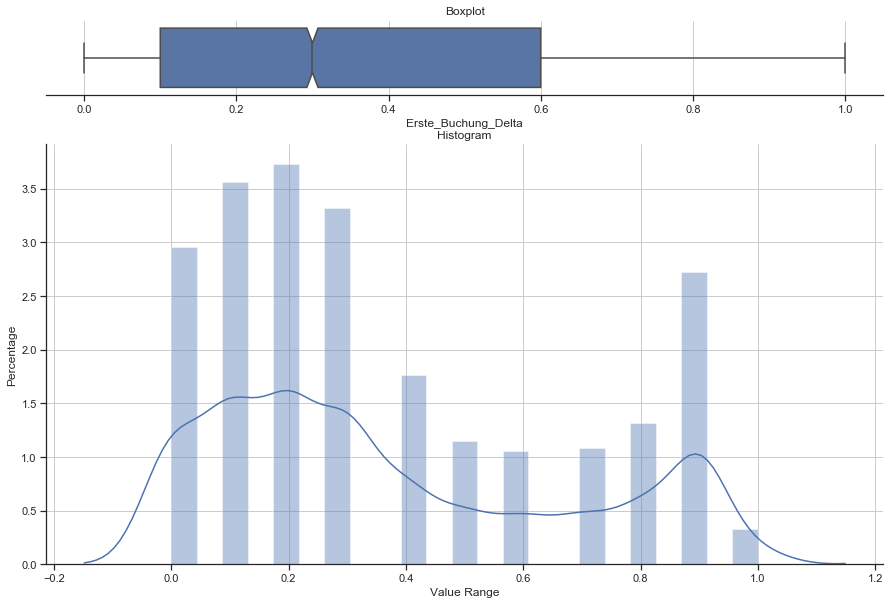

Target_Res_flg == True


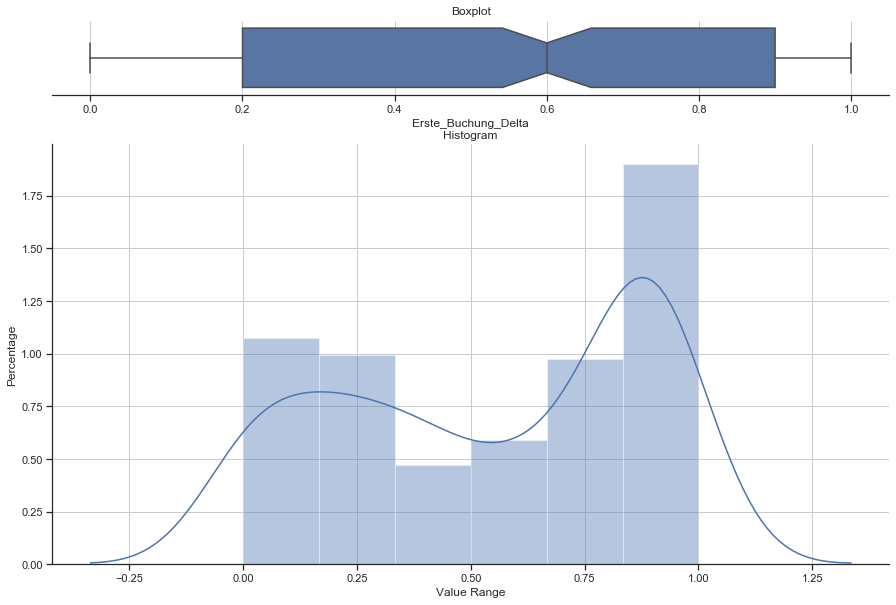

Target_Res_flg == False


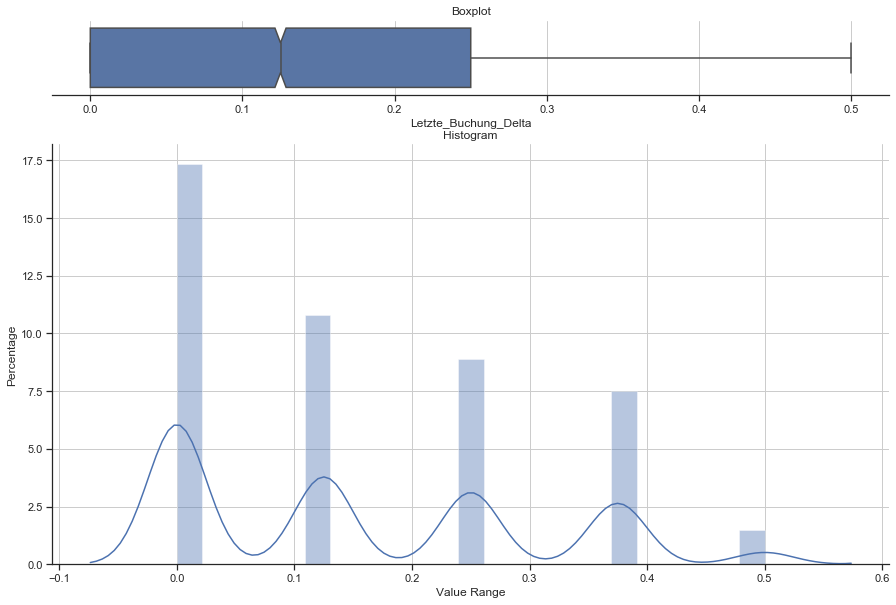

Target_Res_flg == True


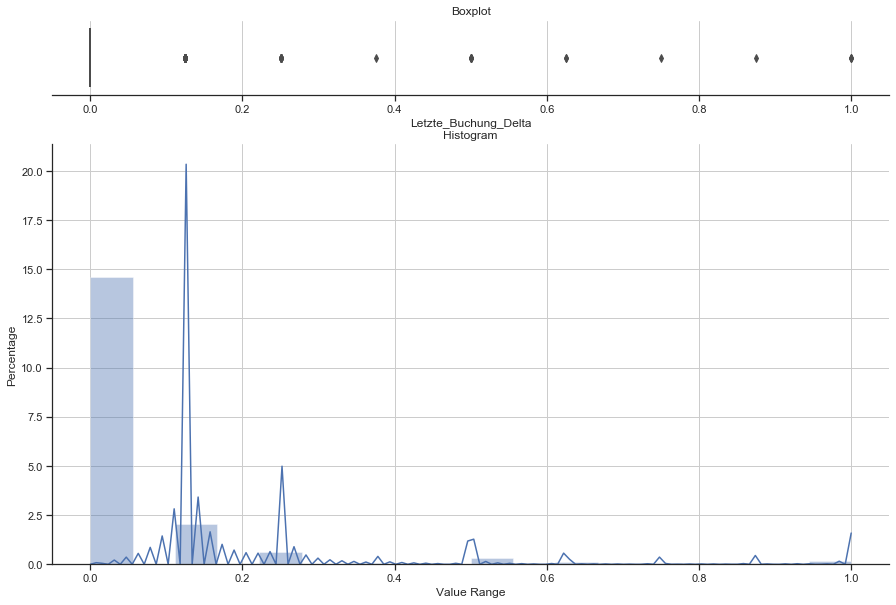

Target_Res_flg == False


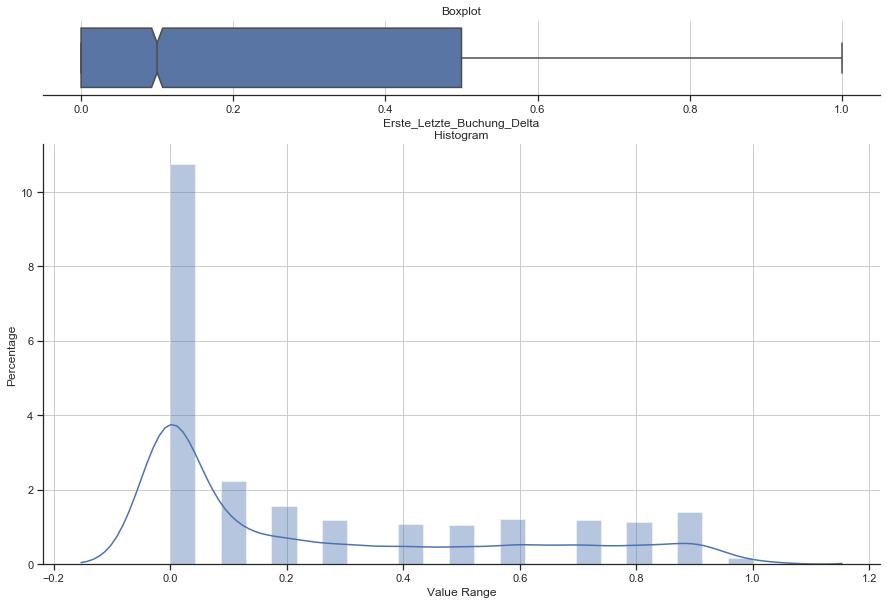

Target_Res_flg == True


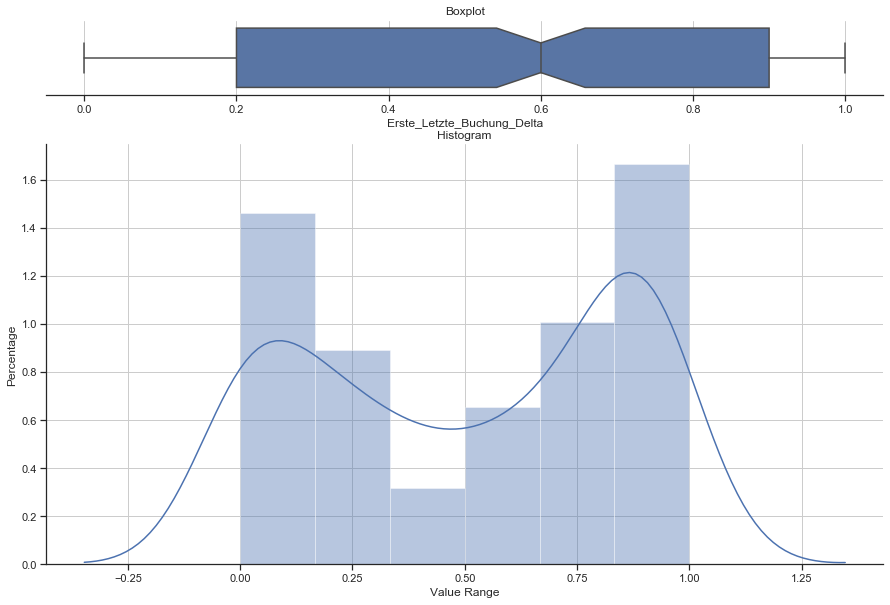

In [11]:
temp_df = training_all
print("Target_Res_flg == False")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == False ,"Erste_Buchung_Delta"])
print("Target_Res_flg == True")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == True ,"Erste_Buchung_Delta"])

print("Target_Res_flg == False")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == False ,"Letzte_Buchung_Delta"])
print("Target_Res_flg == True")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == True ,"Letzte_Buchung_Delta"])


print("Target_Res_flg == False")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == False ,"Erste_Letzte_Buchung_Delta"])
print("Target_Res_flg == True")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == True ,"Erste_Letzte_Buchung_Delta"])

## CRM Data

In [12]:
from vkprog_crm_prep  import crm_train_scoring

In [13]:
(crm_train_df, crm_score_df,feature_colnames_crm) = crm_train_scoring(
    day=21,
    month=10,
    year_score=2019,
    year_train=2018,
    year_span=4)

2019-10-28 16:16:15 [INFO] Start.
2019-10-28 16:16:15 [INFO] Started loading binary file
2019-10-28 16:16:15 [INFO] Reading from file C:\Users\stc\data\vkprog\crm_data_vkprog.feather
2019-10-28 16:16:15 [INFO] Finished loading binary file in 0.2s (0.33s CPU)
2019-10-28 16:16:26 [INFO] Finished.


In [14]:
from pa_lib.data import desc_col

In [15]:
def scaling_crm_add2master(master_df,crm_df,feature_colnames_crm):
    
    container_df = pd.merge(master_df, crm_df,how="left", on="Endkunde_NR")

    for col_name in list(np.compress(['RY'== x[0:2] for x in feature_colnames_crm],feature_colnames_crm)):
        container_df.loc[:,col_name] = container_df.loc[:,col_name].fillna(0)
        max_ = np.nanmax(container_df.loc[:,col_name])
        min_ = np.nanmin(container_df.loc[:,col_name])
        if min_ == max_:
            container_df.loc[:,col_name] = 0
        else:
            container_df.loc[:,col_name] = (container_df.loc[:,col_name] - min_)/(max_ - min_)

    for col_name in list(np.compress(['Letzter'== x[0:7] for x in feature_colnames_crm],feature_colnames_crm)):
        max_ = np.nanmax(container_df.loc[:,col_name]) # those who have never been contacted will be put together with the max-ones.
        container_df.loc[:,col_name] = container_df.loc[:,col_name].fillna(max_) # No more NaNs!
        min_ = np.nanmin(container_df.loc[:,col_name])
        
        if max_ == min_:
            container_df.loc[:,col_name] = 1
        else:
            container_df.loc[:,col_name] = container_df.loc[:,col_name]/max_ # scaling, doesn't need 0
    
    return container_df

In [16]:
training_all = scaling_crm_add2master(master_df            = training_all,
                                          crm_df               = crm_train_df,
                                          feature_colnames_crm = feature_colnames_crm)

In [17]:
scoring_all  = scaling_crm_add2master(master_df=scoring_all, crm_df=crm_score_df,feature_colnames_crm=feature_colnames_crm)

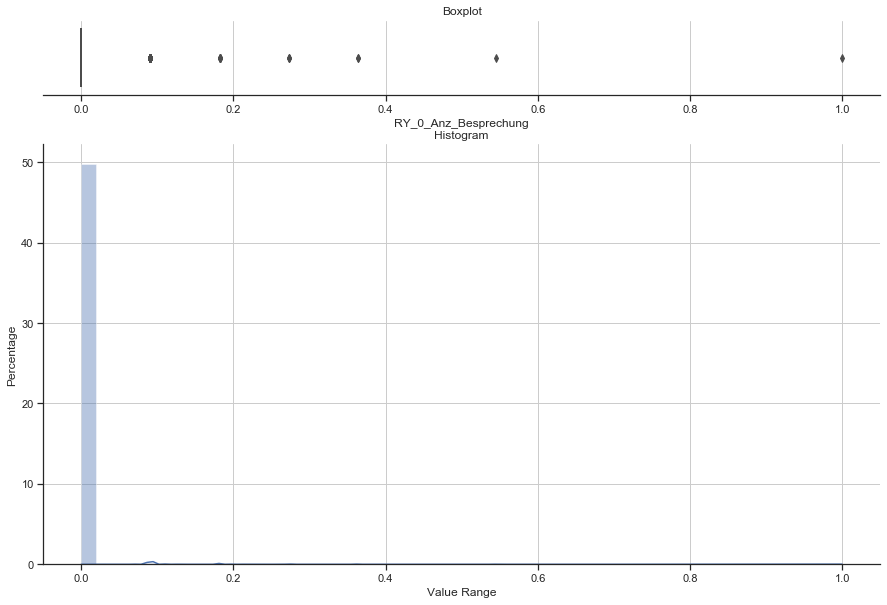

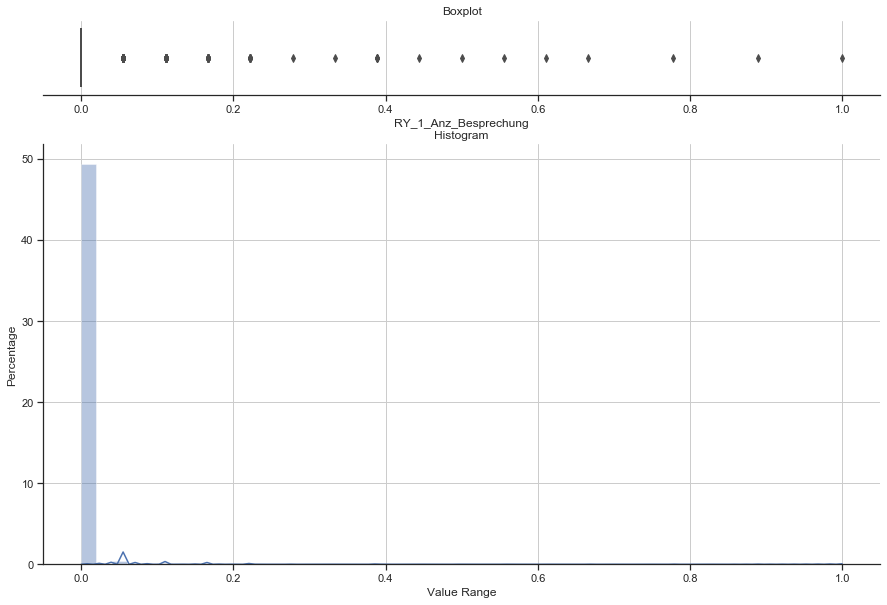

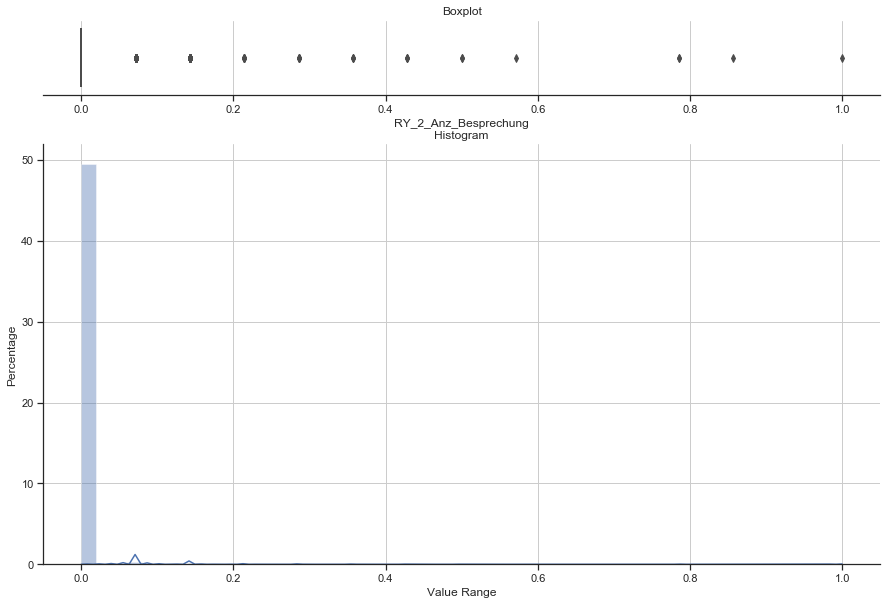

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


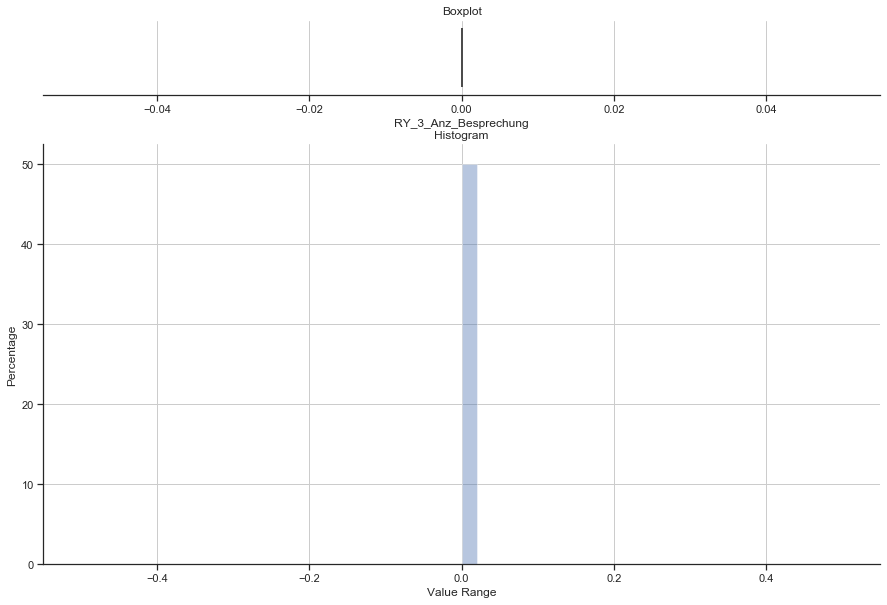

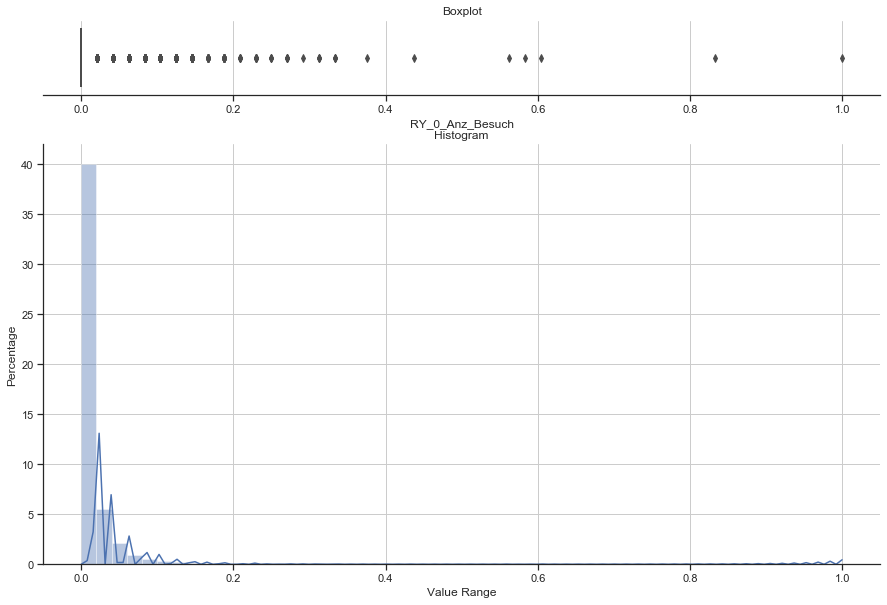

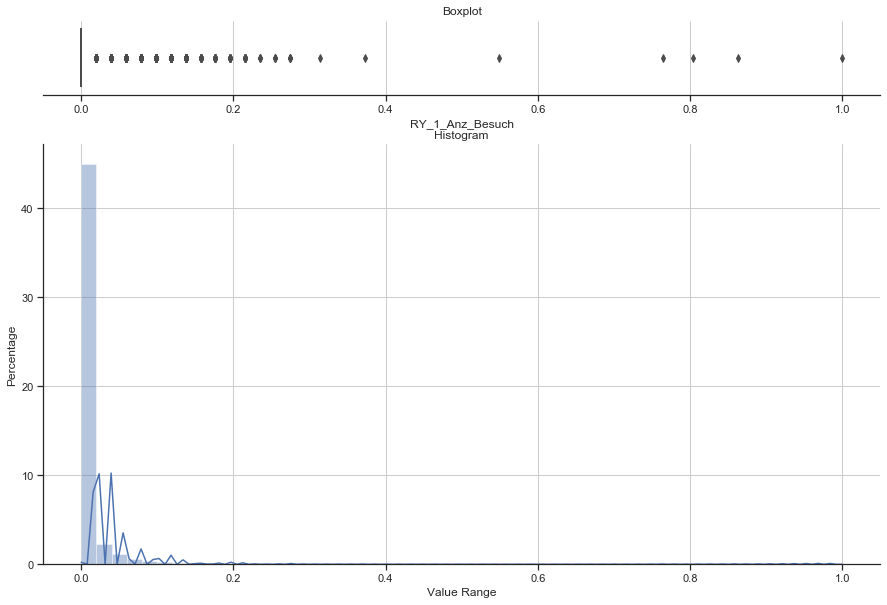

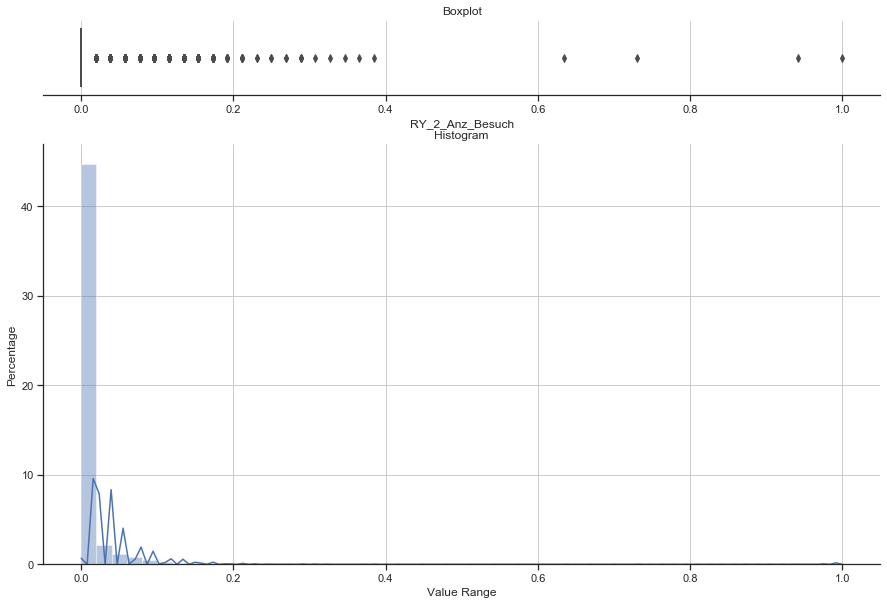

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


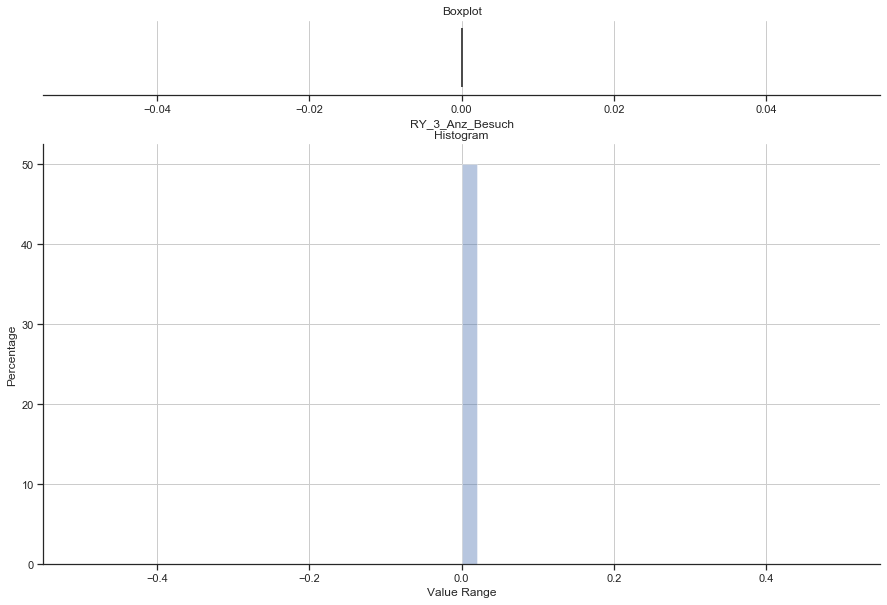

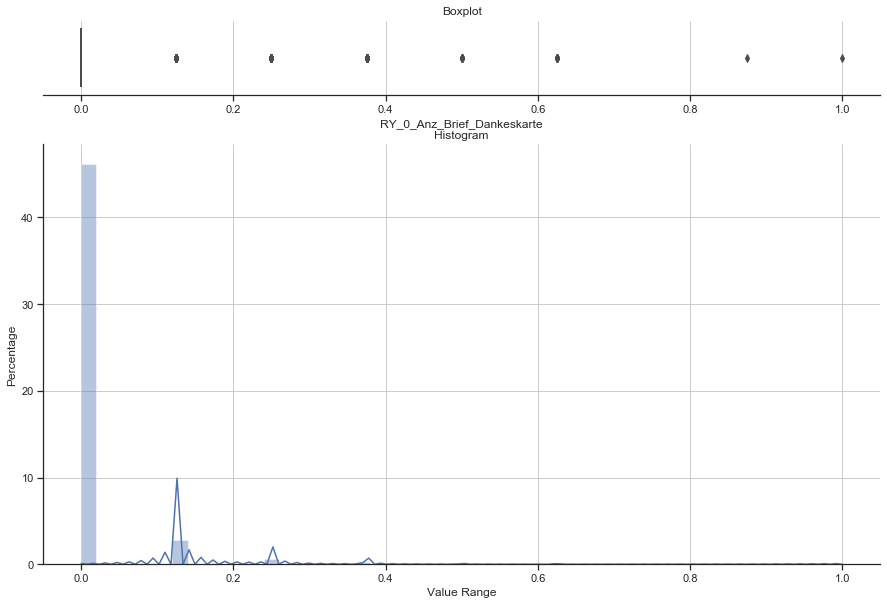

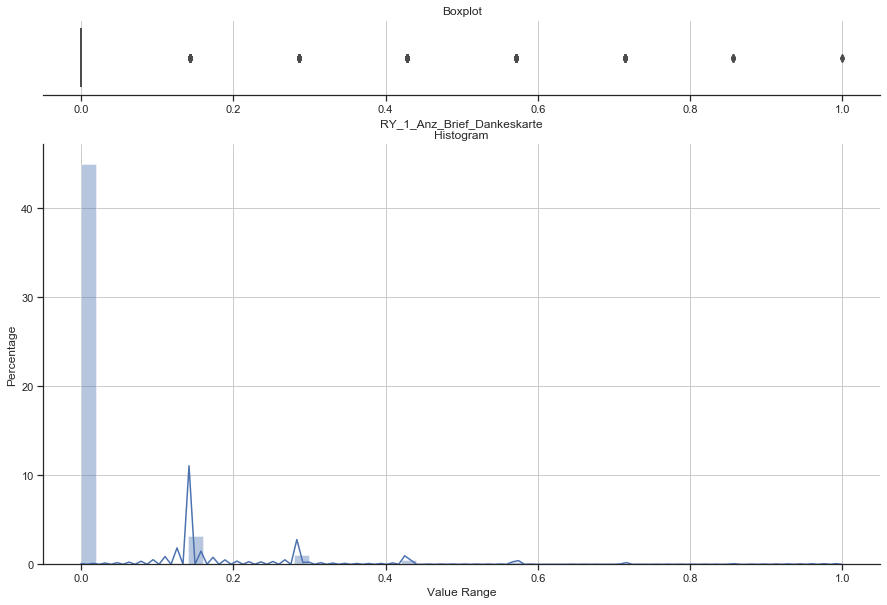

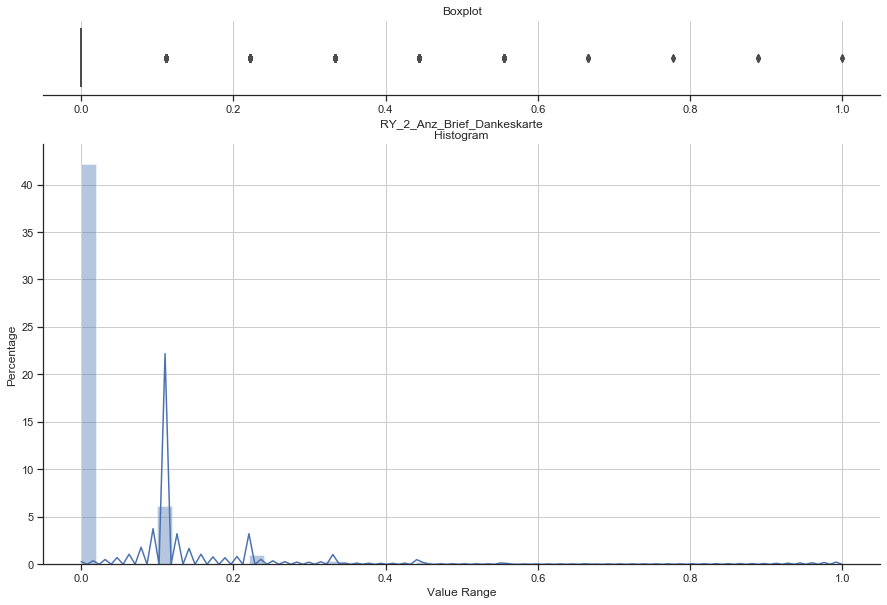

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


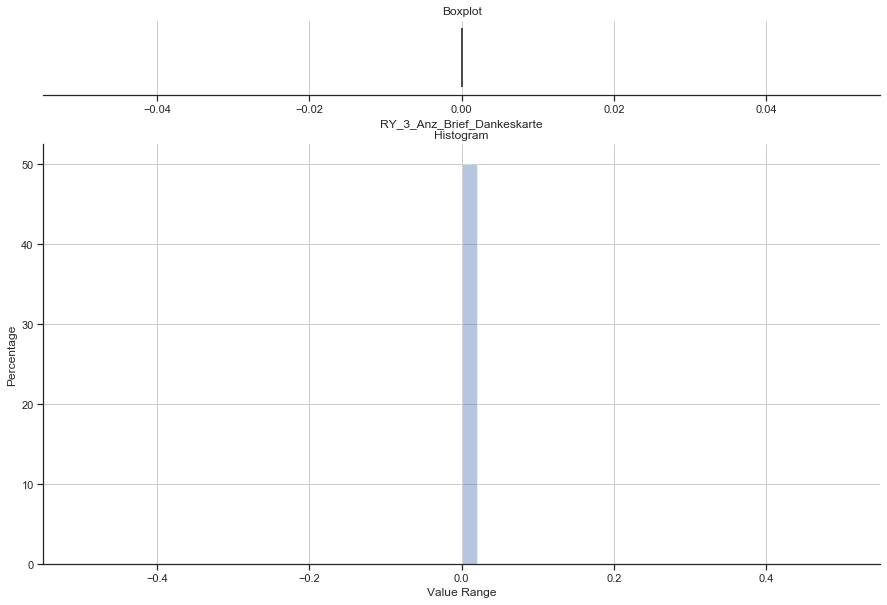

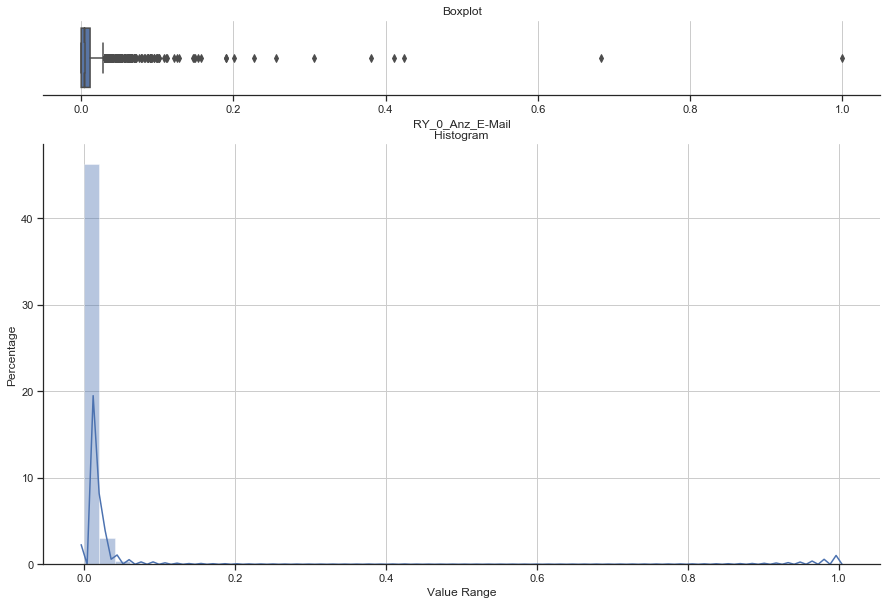

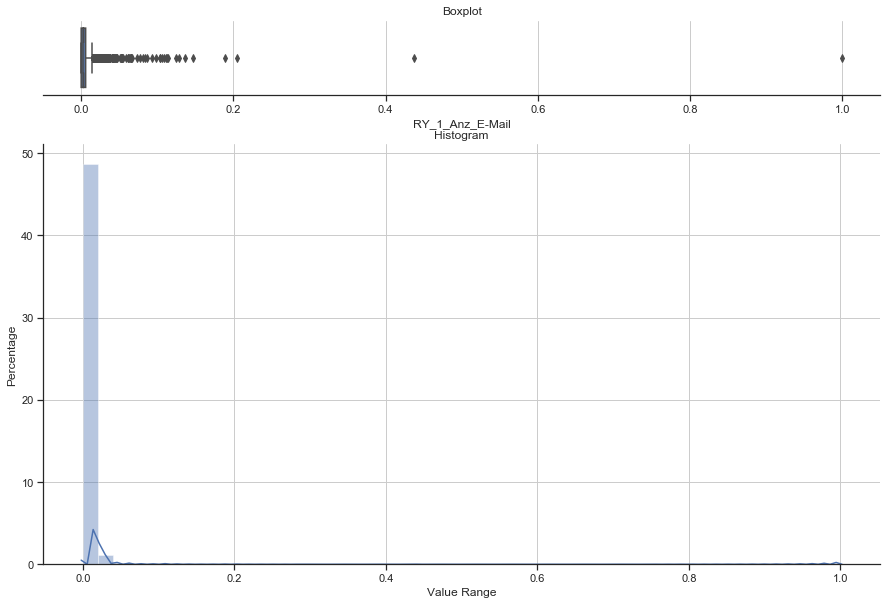

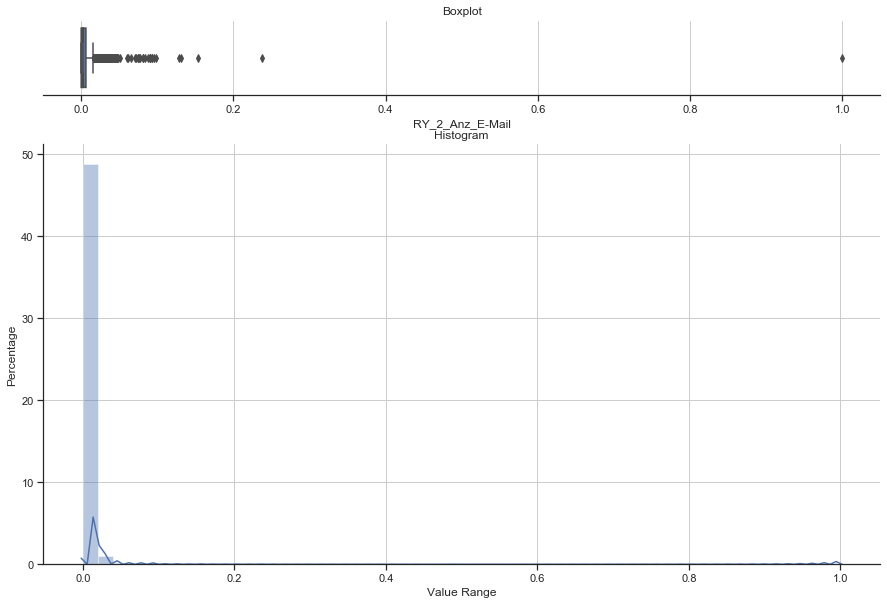

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


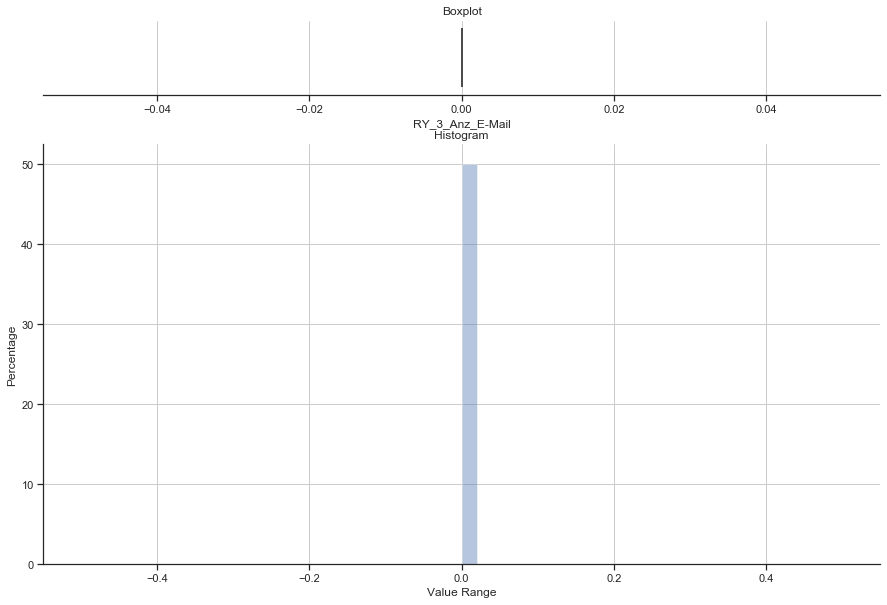

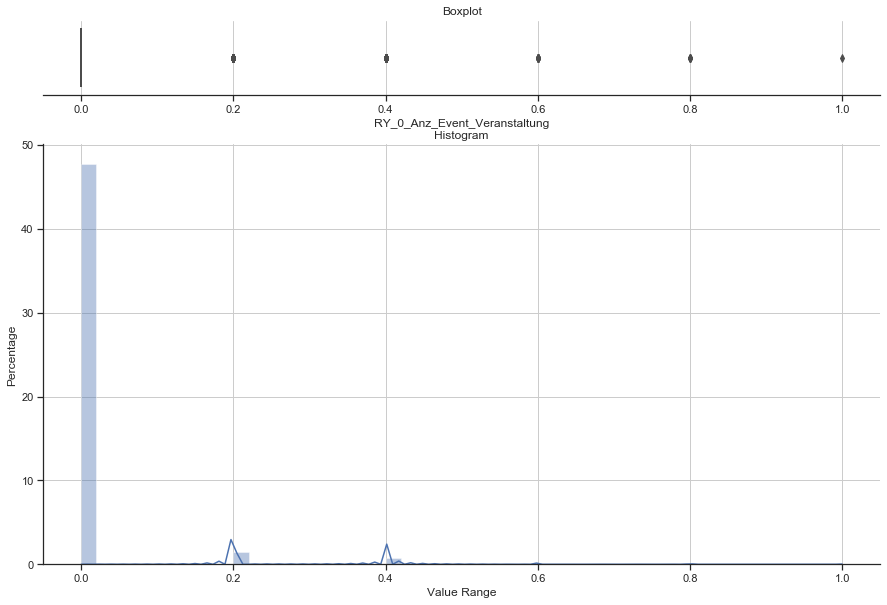

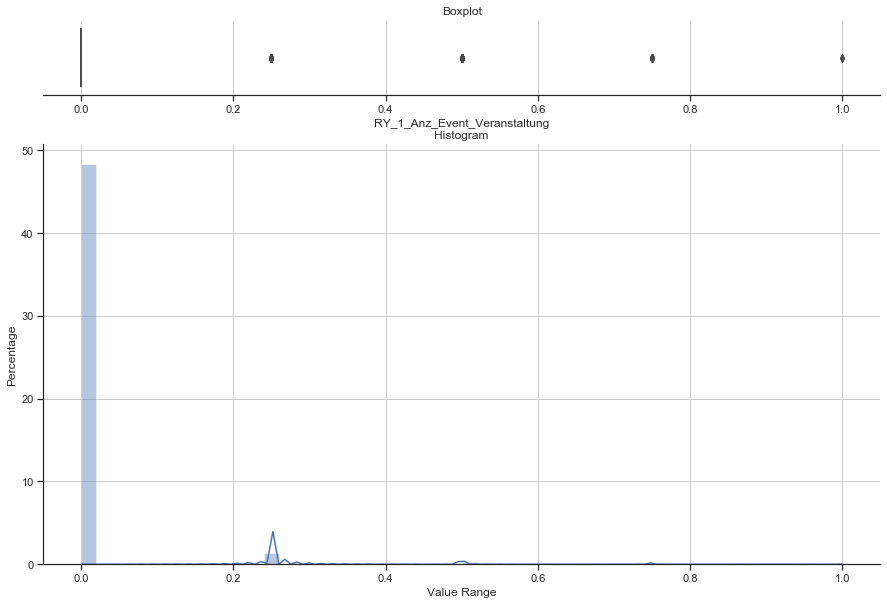

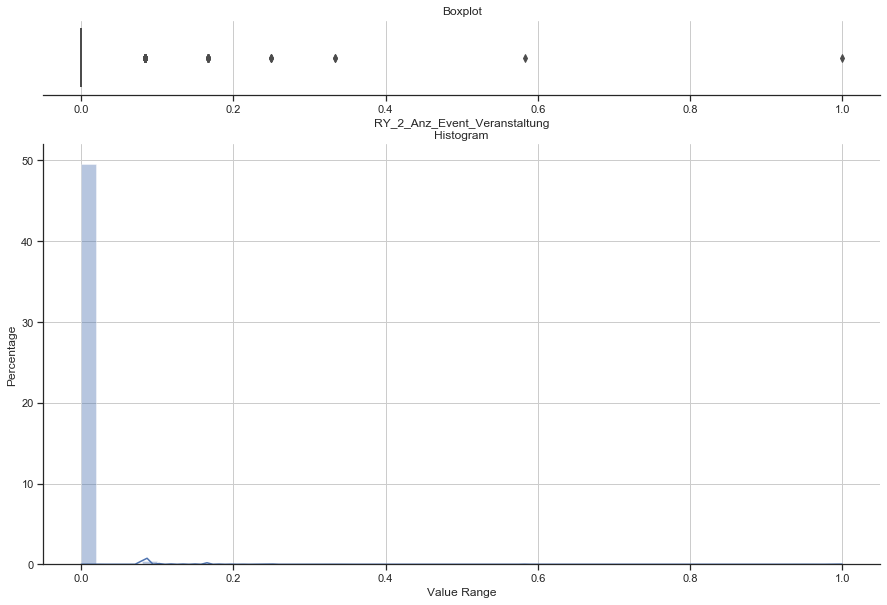

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


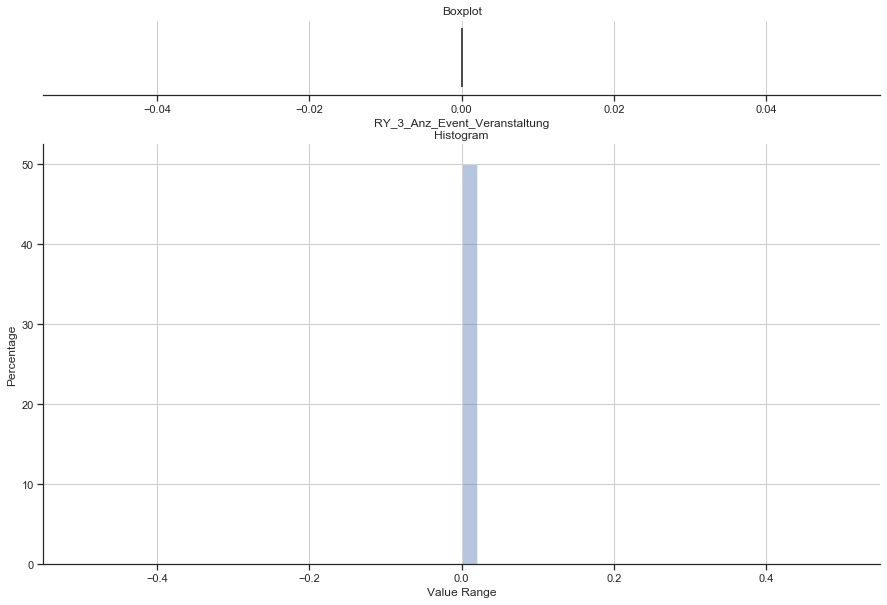

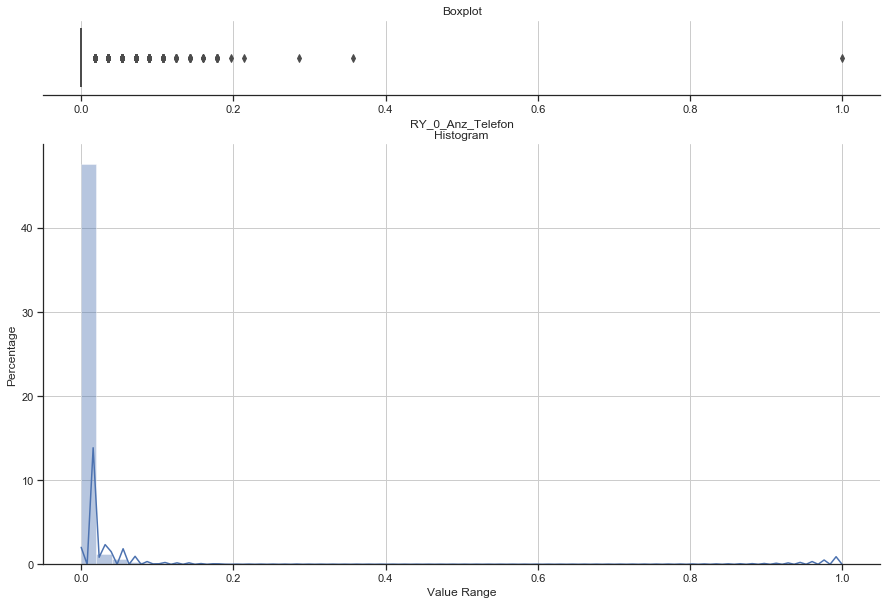

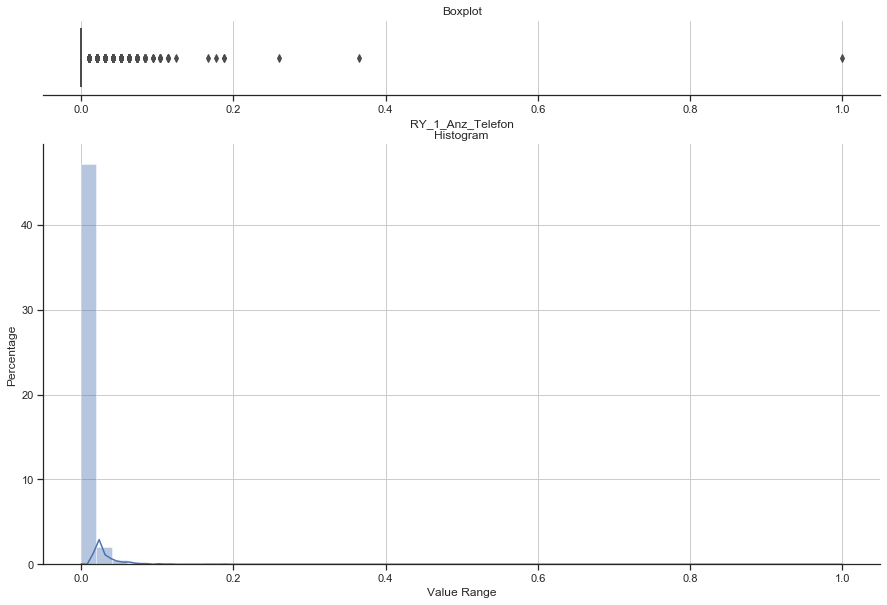

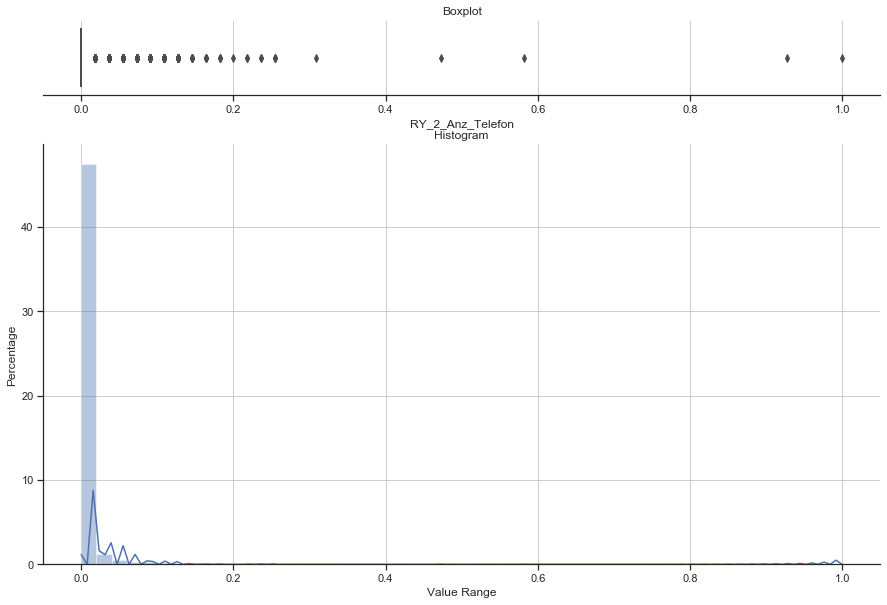

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


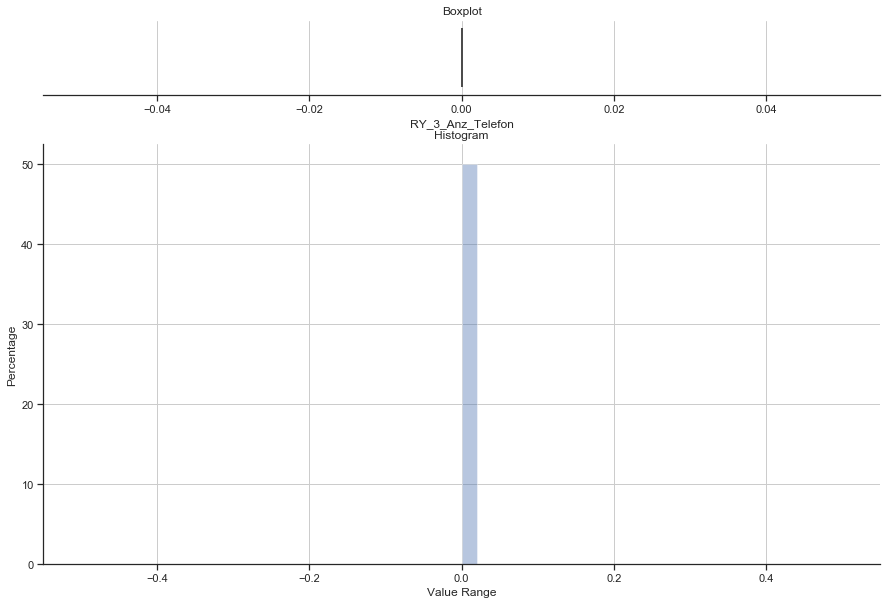

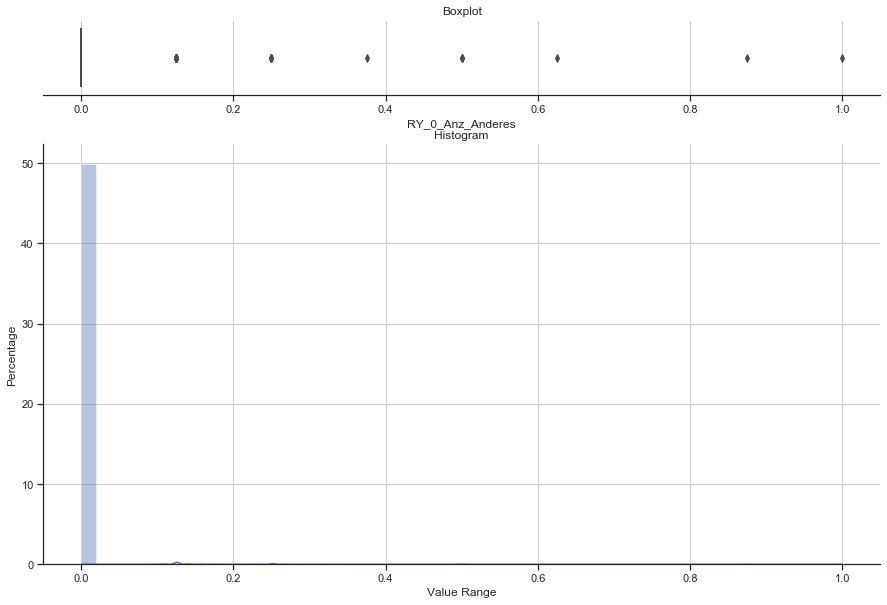

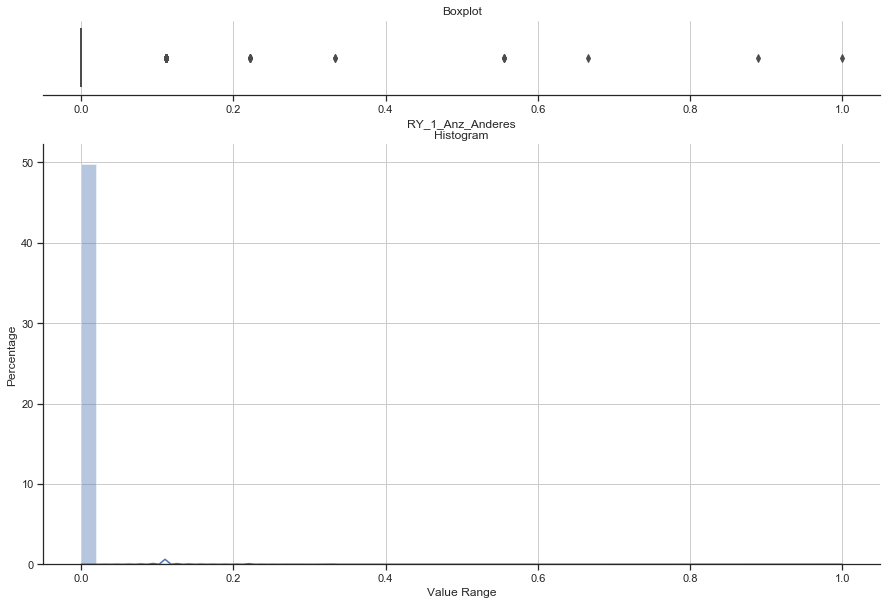

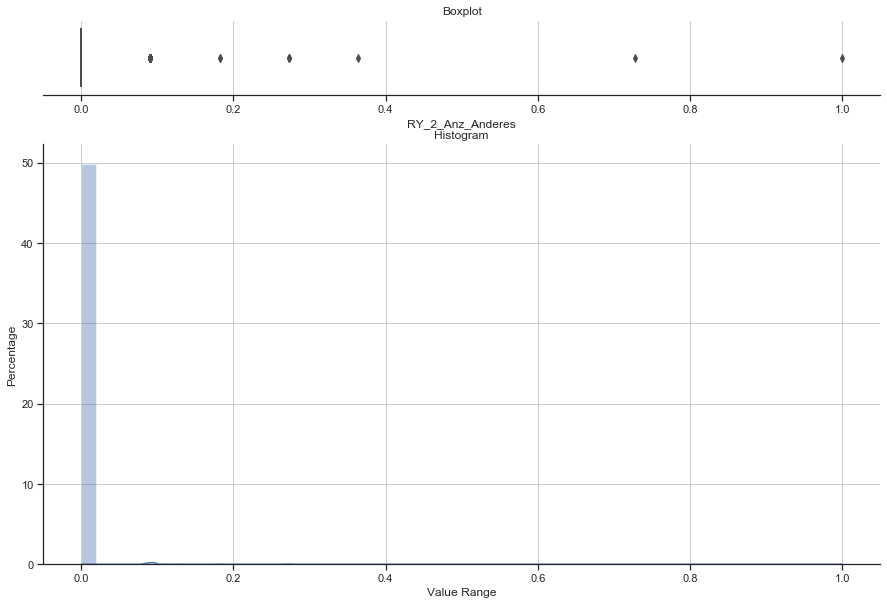

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


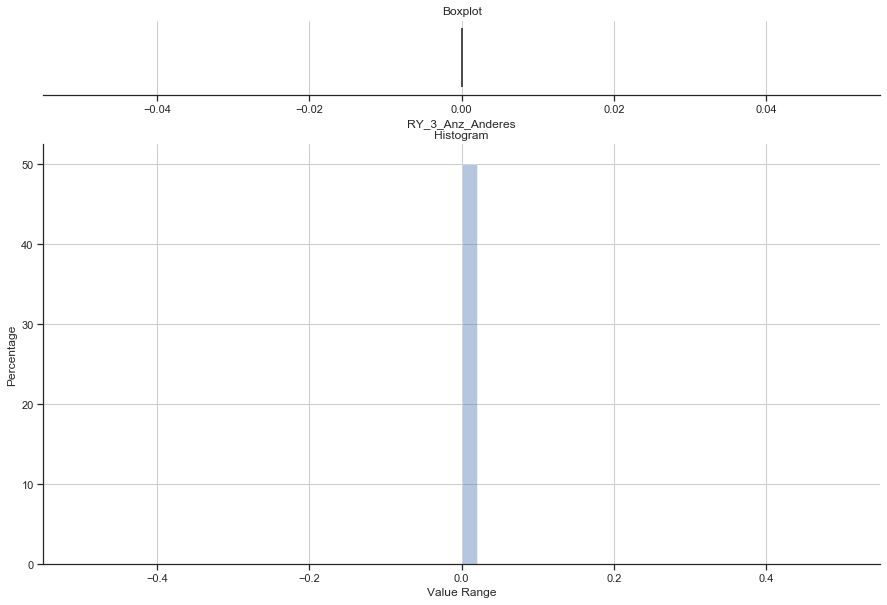

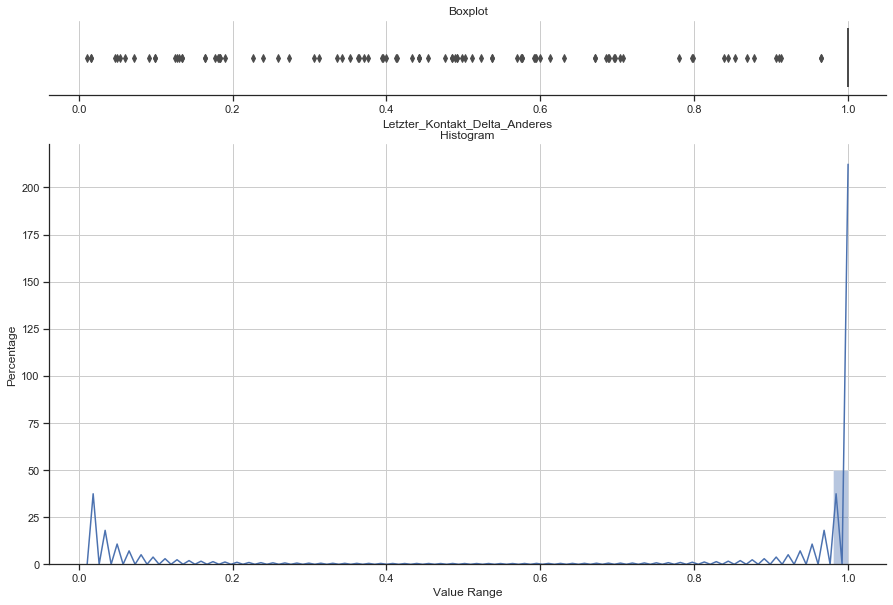

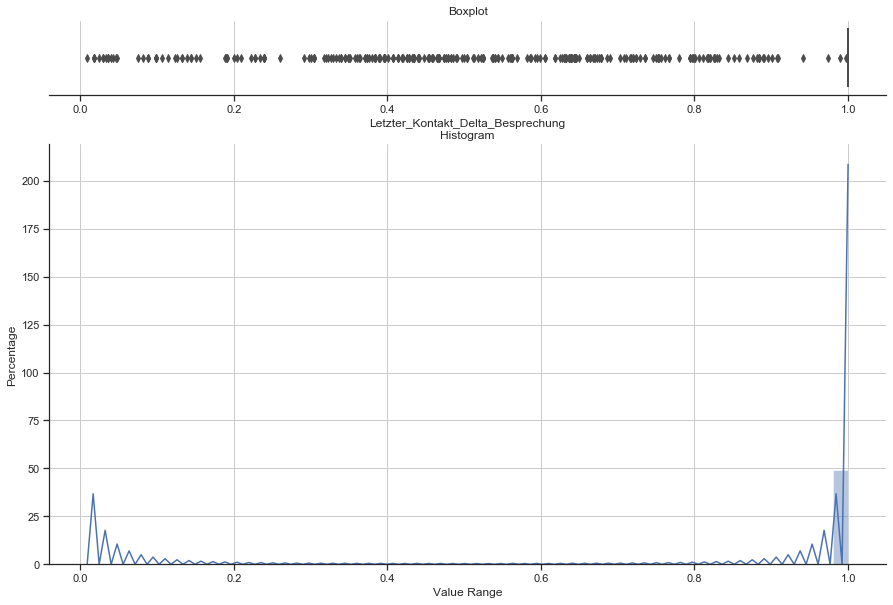

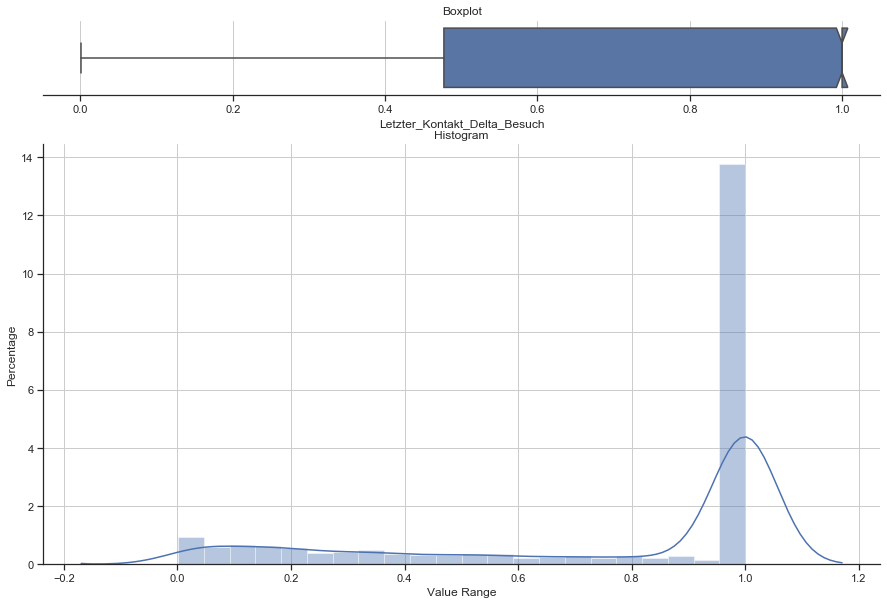

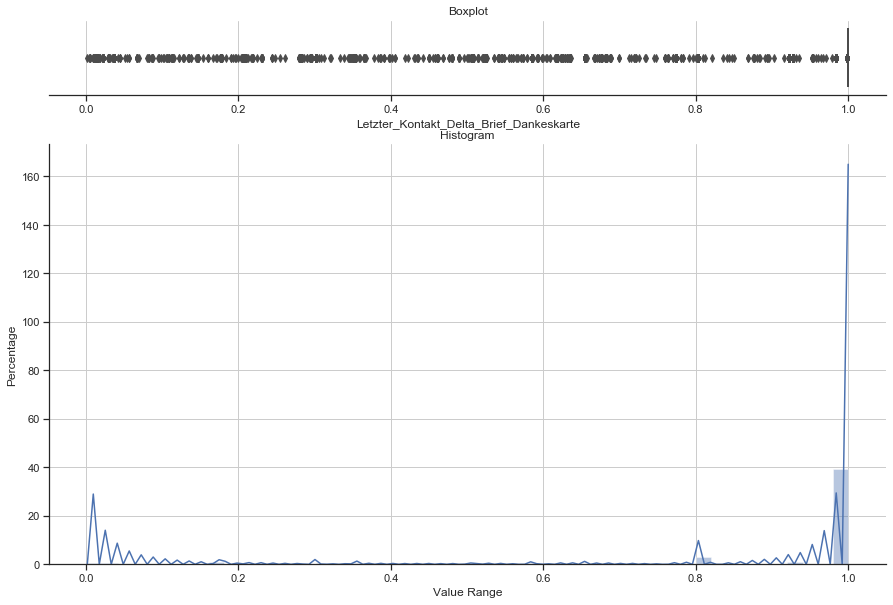

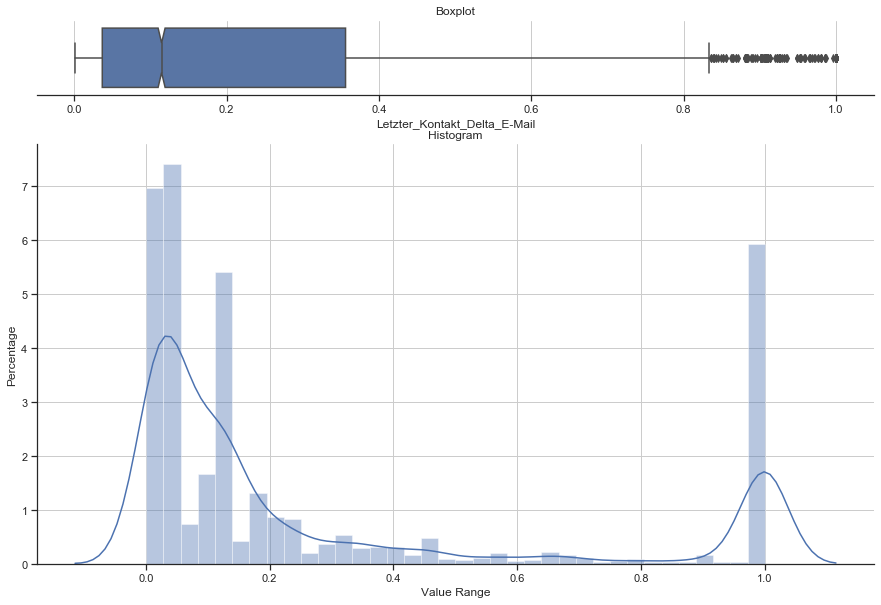

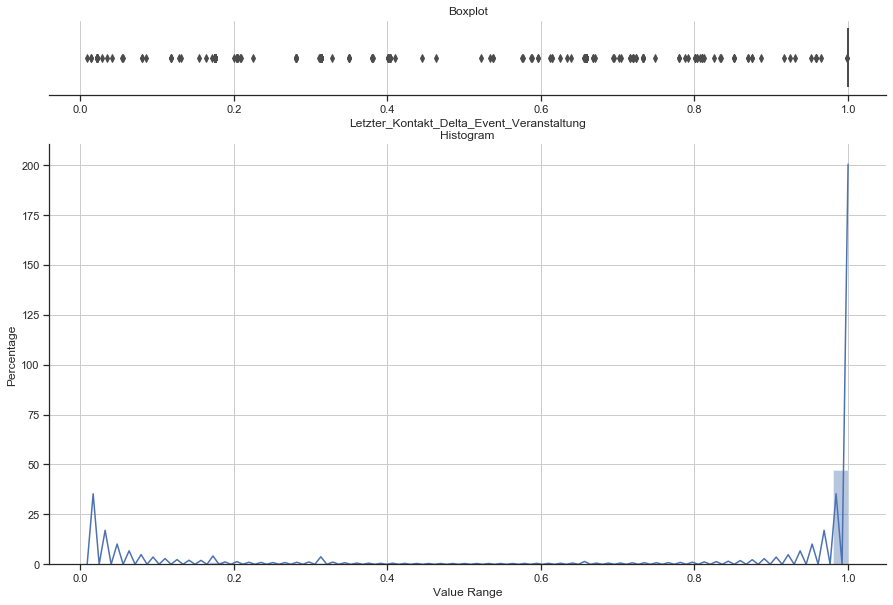

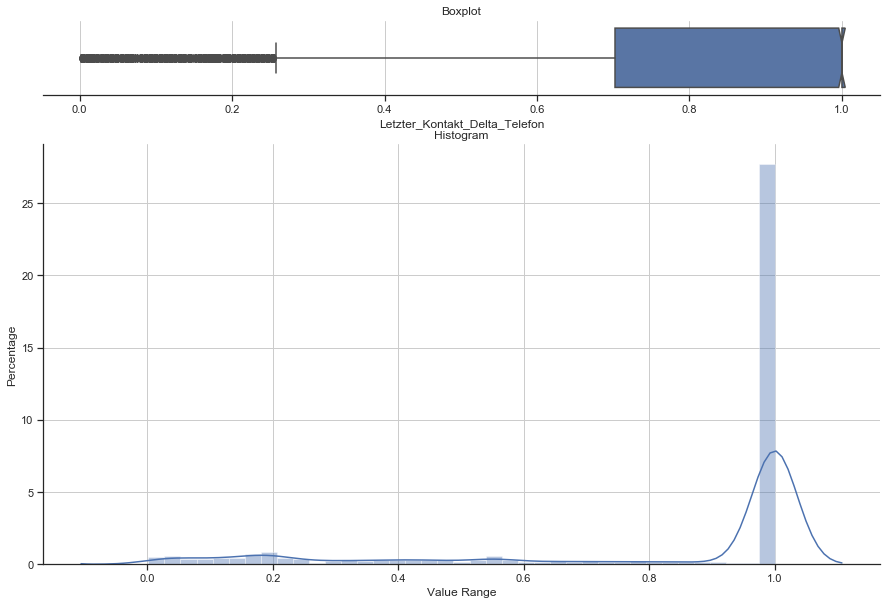

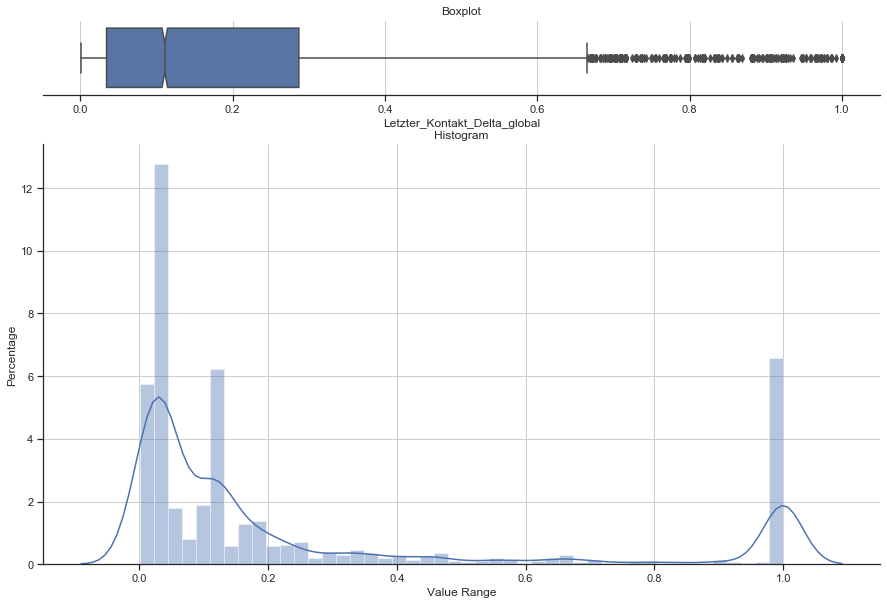

In [18]:
for x in feature_colnames_crm:
    boxplot_histogram(training_all.loc[:,x])

In [19]:
#desc_col(__training_all__).sort_values("NULLS",ascending=False).head(10)

In [20]:
#desc_col(__scoring_all__).sort_values("NULLS",ascending=False).head(10)

In [21]:
print(training_all.shape)
print(scoring_all.shape)

(11915, 345)
(12012, 345)


# Modeling

## Define Columns: Features versus Targets

In [22]:
from itertools import compress
features = feature_colnames_bd + feature_colnames_dates + feature_colnames_branchen + feature_colnames_crm
#feature_columns = list(compress(features,["Target" not in s for s in features]))

feature_columns_boolean = pd.Series(features).str.match('^Target')
feature_columns = pd.Series(features).loc[~feature_columns_boolean]

feature_columns_boolean = pd.Series(training_all.columns).str.match('^Target')
target_columns = pd.Series(training_all.columns).loc[feature_columns_boolean]

del feature_columns_boolean

#target_columns  = list(compress(training_all.columns,["Target" in s for s in training_all.columns]))

In [23]:
print(len(feature_columns))
print(target_columns)

338
214               Target_Aus_flg
215               Target_Res_flg
216    Target_Sum_Aus_RY_0_KW_43
217    Target_Sum_Res_RY_0_KW_43
dtype: object


In [24]:
#["Target" not in s for s in features]
#features
#display(feature_columns)

## Split ``training_all`` into training-set (``X_train``,``y_train``) and test-set (``X_test``,``y_test``)

In [25]:
df_features = training_all.loc[:,feature_columns].to_numpy()
df_target   = training_all.loc[:, "Target_Res_flg"].to_numpy()

df_scoring_features = scoring_all.loc[:,feature_columns].to_numpy()

In [26]:
print(df_features.shape)
print(df_target.shape)

(11915, 338)
(11915,)


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    #df_features, df_target, train_size=0.80, random_state=42)
    df_features, df_target, train_size=0.75, random_state=42)

In [28]:
print("Shape:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("\ndf_scoring_features", df_scoring_features.shape)

Shape:
X_train: (8936, 338)
y_train: (8936,)
X_test: (2979, 338)
y_test: (2979,)

df_scoring_features (12012, 338)


In [29]:
from scipy import stats
print('y_train:')
print(pd.DataFrame(y_train).groupby(0)[0].count())
print(stats.describe(y_train))

print('\ny_test:')
print(pd.DataFrame(y_test).groupby(0)[0].count())
print(stats.describe(y_test))


y_train:
0
False    8681
True      255
Name: 0, dtype: int64
DescribeResult(nobs=8936, minmax=(False, True), mean=0.028536257833482542, variance=0.02772504244571482, skewness=5.663259816653987, kurtosis=30.072511750927774)

y_test:
0
False    2877
True      102
Name: 0, dtype: int64
DescribeResult(nobs=2979, minmax=(False, True), mean=0.03423967774420947, variance=0.03307842608129303, skewness=5.122629788540117, kurtosis=24.241335950438565)


## Balance Training Dataset

In [30]:
from imblearn.over_sampling import SMOTE
#ros = RandomOverSampler(random_state=42)
sm  = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

In [31]:
print('y_train_balanced:')
print(pd.DataFrame(y_train_balanced).groupby(0)[0].count())
print(stats.describe(y_train_balanced))

y_train_balanced:
0
False    8681
True     8681
Name: 0, dtype: int64
DescribeResult(nobs=17362, minmax=(False, True), mean=0.5, variance=0.2500144000921606, skewness=0.0, kurtosis=-2.0)


## Feature selection: SelectkBest

``SelectPercentile`` removes all but a user-specified highest scoring percentage of features.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html

In [32]:
#from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif # ANOVA F-value
from sklearn.feature_selection import mutual_info_classif
from itertools import compress

In [33]:
%%time
#Wall time: 54 s

# use f_classif (the default) and SelectPercentile to select 50% of features
"""
select = SelectPercentile(score_func=mutual_info_classif,
                          percentile=100)
"""
select = SelectKBest(score_func=mutual_info_classif,
            k=150 # How many features? (currently 219 is max)
            )
select.fit(X_train_balanced, y_train_balanced)

mask = select.get_support() # boolean array.

Wall time: 35.2 s


In [34]:
print("X_train_balanced.shape: {}".format(X_train_balanced.shape))
print("X_train_balanced[:,mask].shape: {}".format(X_train_balanced[:,mask].shape))

X_train_balanced.shape: (17362, 338)
X_train_balanced[:,mask].shape: (17362, 150)


In [35]:
feature_columns  = feature_columns.loc[mask]
X_train_balanced = X_train_balanced[:,mask]
X_train          = X_train[:,mask]
X_test           = X_test[:,mask]
X_scoring        = df_scoring_features[:,mask]

In [36]:
print("X_scoring:",X_scoring.shape)

X_scoring: (12012, 150)


## Model Training

### Logistic Regression (base model)

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
%%time
# Wall time: 1min 13s
logreg_C1000 = LogisticRegression(n_jobs=-1,
                               solver="sag",
                               max_iter=100000,
                               C=1000 #adjustable, bigger mean less restriction on coefficients
                              ).fit(X_train_balanced, y_train_balanced) # bigger C

print("Training set score: {:.3f}".format(logreg_C1000.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg_C1000.score(X_test, y_test)))

Training set score: 0.839
Test set score: 0.818
Wall time: 28.9 s


In [39]:
%%time
# Wall time: 543 ms
logreg_C0001 = LogisticRegression(n_jobs=-1,
                               solver="sag",
                               max_iter=100000,
                               C=0.001 #adjustable, bigger mean less restriction on coefficients
                              ).fit(X_train_balanced, y_train_balanced) # bigger C

print("Training set score: {:.3f}".format(logreg_C0001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg_C0001.score(X_test, y_test)))

Training set score: 0.740
Test set score: 0.756
Wall time: 431 ms


#### Plot Coefficients

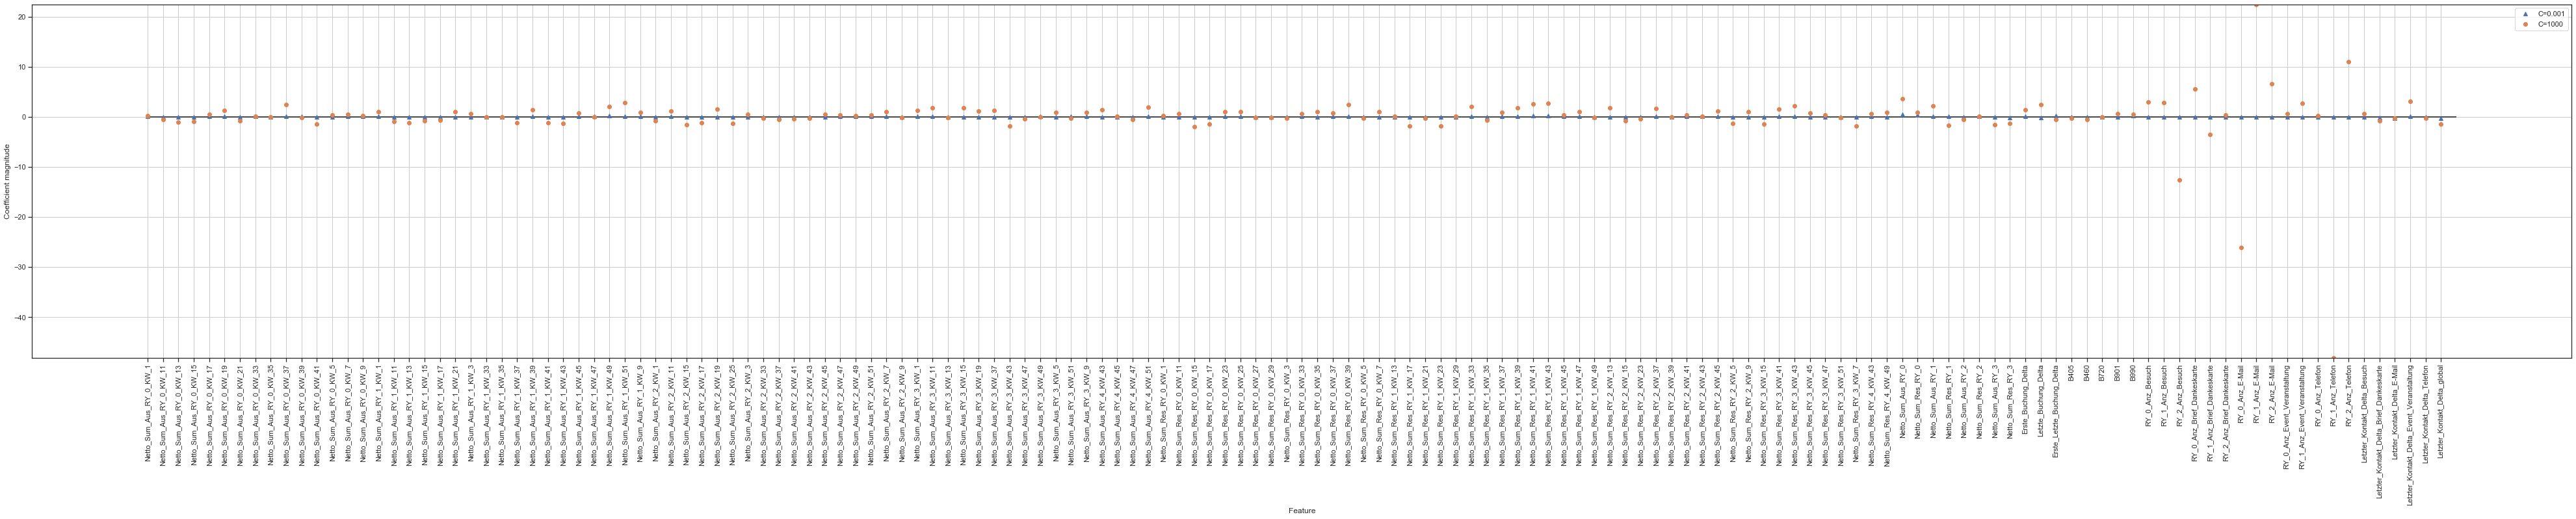

In [40]:
# %% Plot: Compare LogReg-coefficients for different C (1000, 0.001)
plt.figure(figsize=(70,10))
plt.grid()
plt.plot(logreg_C0001.coef_.T, '^', label="C=0.001")
plt.plot(logreg_C1000.coef_.T,    'o', label="C=1000")
plt.xticks(range(len(feature_columns)), feature_columns, rotation=90)
plt.hlines(0, 0, len(feature_columns))
plt.ylim(min(logreg_C1000.coef_.T), max(logreg_C1000.coef_.T))
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

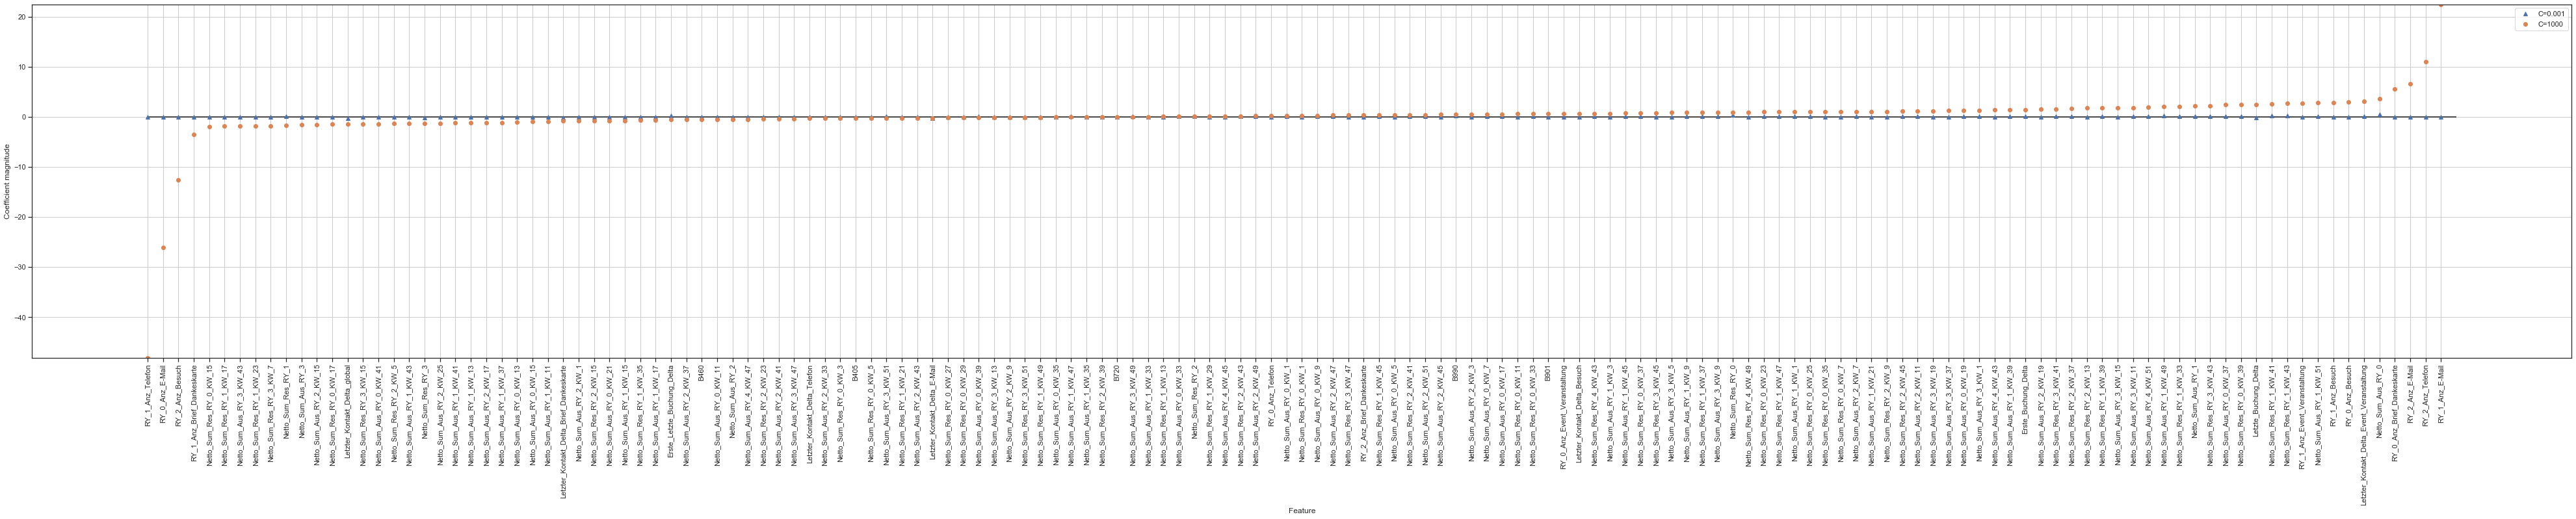

In [41]:
test_df = pd.DataFrame(data={'feature': pd.Series(feature_columns), 
                             'C1000': list(logreg_C1000.coef_.T),
                            'C0001': list(logreg_C0001.coef_.T)})
test_df = test_df.sort_values(by=['C1000']).reset_index()

# %% Plot: Compare LogReg-coefficients for different C (1000, 0.001)
plt.figure(figsize=(70,10))
plt.grid()
plt.plot(test_df.loc[:,'C0001'], '^', label="C=0.001")
plt.plot(test_df.loc[:,'C1000'], 'o', label="C=1000")
plt.xticks(range(len(feature_columns)), test_df.loc[:,'feature'], rotation=90)
plt.hlines(0, 0, len(feature_columns))
plt.ylim(min(logreg_C1000.coef_.T), max(logreg_C1000.coef_.T))
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

### Model Training: Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
%%time 
# Wall time: 13min
forest_01 = RandomForestClassifier(n_estimators=5*10**3,
                                max_depth=10,
                                criterion='gini',  #criterion='gini',
                                random_state=42,
                                n_jobs=-1)
forest_01.fit(X_train_balanced, y_train_balanced)
#forest_01.fit(X_train, y_train)

#forest_01.fit(X_train, y_train)

Wall time: 16 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [44]:
%%time
# %% Validate Accuracy
print("Accuracy on balanced training set: {:.3f}".format(forest_01.score(X_train_balanced,y_train_balanced)))
print("Accuracy on unbalanced training set: {:.3f}".format(forest_01.score(X_train,y_train)))
print("Accuracy on test set: {:.3f}".format(forest_01.score(X_test,     y_test)))

Accuracy on balanced training set: 0.981
Accuracy on unbalanced training set: 0.972
Accuracy on test set: 0.937
Wall time: 4.96 s


In [45]:
# %% Plot: Feature importance
def plot_feature_importances(model,feature_columns,figsize=(20,100)):
    from operator import itemgetter
    dict_feature_importance = sorted(dict(zip(feature_columns,model.feature_importances_)).items(), key=itemgetter(1))
    n_features              = len(feature_columns)
    
    plt.figure(figsize=figsize)
    plt.grid()
    plt.barh(np.arange(n_features),
             [y for (x,y) in dict_feature_importance],
             align='center')
    plt.yticks(np.arange(n_features), [x for (x,y) in dict_feature_importance])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

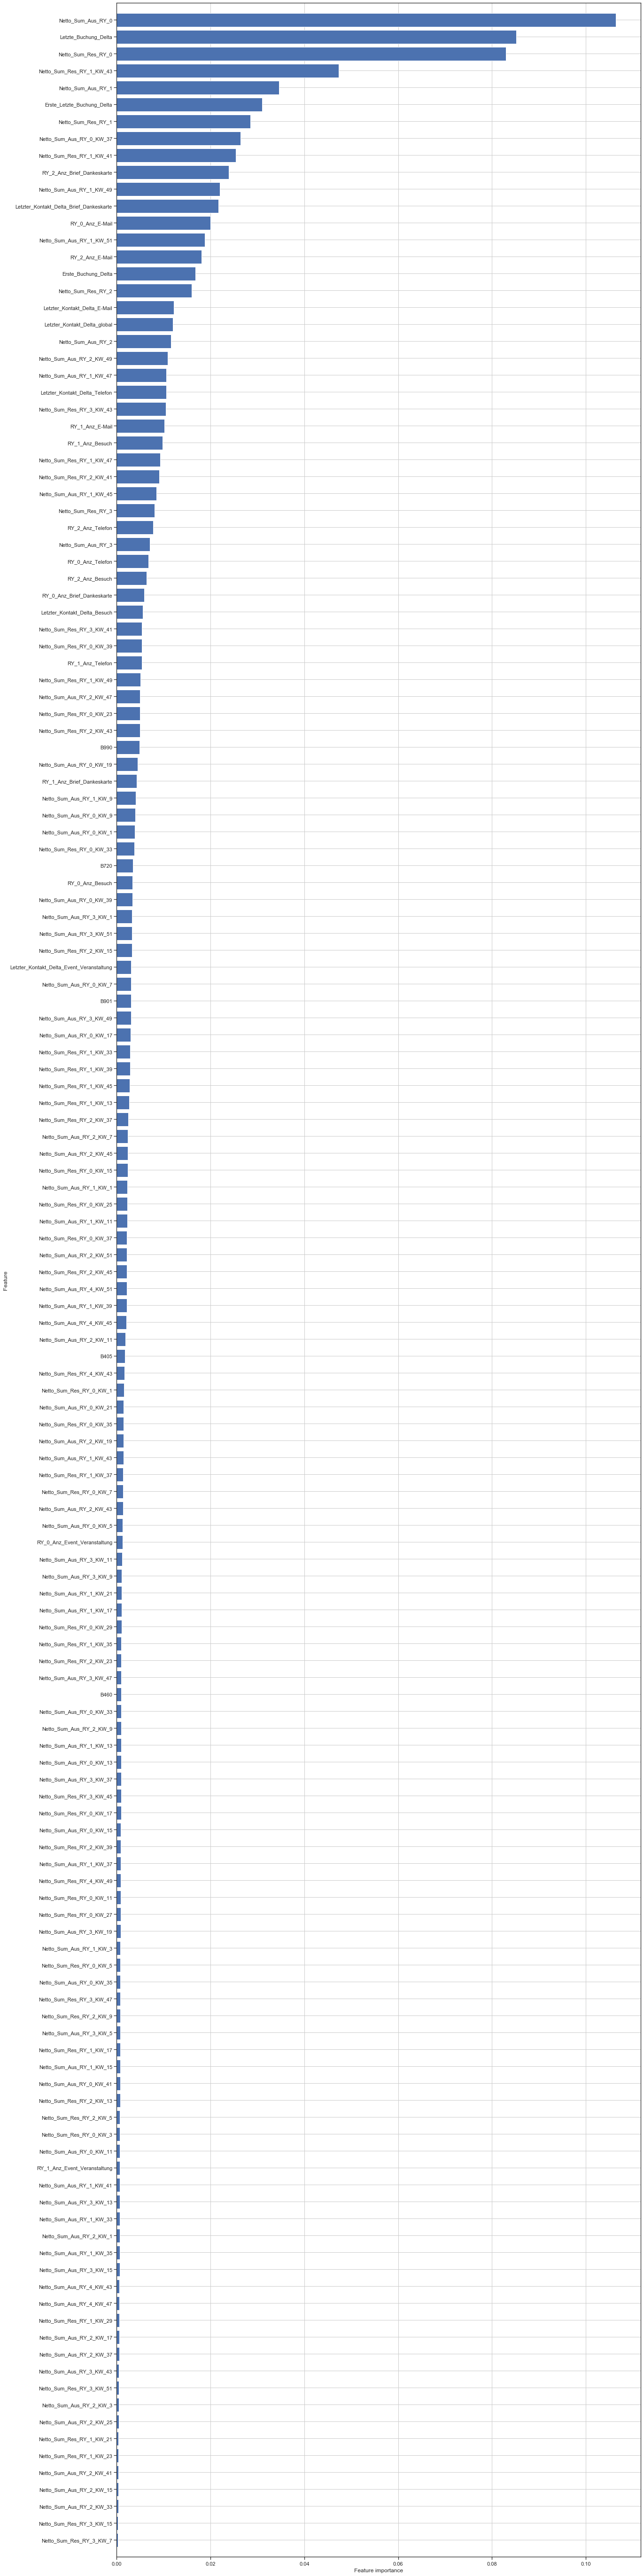

In [46]:
plot_feature_importances(forest_01,feature_columns)

# Model Validation

## Confusion Matrix

In [47]:
from sklearn.metrics import confusion_matrix

In [48]:
%%time

def confusion_matrices(X_test,y_test):
    global pred_forest_01, pred_logreg_C0001, pred_logreg_C1000
    
    pred_forest_01          = forest_01.predict(X_test)
    pred_logreg_C0001       = logreg_C0001.predict(X_test)
    pred_logreg_C1000       = logreg_C1000.predict(X_test)


    # Wall time: 20.9ms

    confusion_logreg_C0001       = confusion_matrix(y_test, pred_logreg_C0001)
    df_confusion_logreg_C0001    = pd.DataFrame(confusion_logreg_C0001, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

    confusion_logreg_C1000       = confusion_matrix(y_test, pred_logreg_C1000)
    df_confusion_logreg_C1000    = pd.DataFrame(confusion_logreg_C1000, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

    confusion_forest_01          = confusion_matrix(y_test, pred_forest_01)
    df_confusion_forest_01       = pd.DataFrame(confusion_forest_01, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

    print("Test set balance:")
    print(pd.Series(y_test).value_counts())

    print("\nConfusion Matrices:")

    print("\nRandom Forest (forest_01):")
    display(df_confusion_forest_01)

    print("\nLogistic Regression C=0.001:")
    display(df_confusion_logreg_C0001)

    print("\nLogistic Regression C=1000:")
    display(df_confusion_logreg_C1000)

Wall time: 0 ns


In [49]:
confusion_matrices(X_train_balanced,y_train_balanced)

Test set balance:
True     8681
False    8681
dtype: int64

Confusion Matrices:

Random Forest (forest_01):


,Pred 0,Pred 1
Fact 0,8484,197
Fact 1,125,8556



Logistic Regression C=0.001:


,Pred 0,Pred 1
Fact 0,6564,2117
Fact 1,2389,6292



Logistic Regression C=1000:


,Pred 0,Pred 1
Fact 0,7177,1504
Fact 1,1294,7387


In [50]:
confusion_matrices(X_train,y_train)

Test set balance:
False    8681
True      255
dtype: int64

Confusion Matrices:

Random Forest (forest_01):


,Pred 0,Pred 1
Fact 0,8484,197
Fact 1,53,202



Logistic Regression C=0.001:


,Pred 0,Pred 1
Fact 0,6564,2117
Fact 1,56,199



Logistic Regression C=1000:


,Pred 0,Pred 1
Fact 0,7177,1504
Fact 1,53,202


In [51]:
confusion_matrices(X_test,y_test)

Test set balance:
False    2877
True      102
dtype: int64

Confusion Matrices:

Random Forest (forest_01):


,Pred 0,Pred 1
Fact 0,2762,115
Fact 1,73,29



Logistic Regression C=0.001:


,Pred 0,Pred 1
Fact 0,2179,698
Fact 1,29,73



Logistic Regression C=1000:


,Pred 0,Pred 1
Fact 0,2376,501
Fact 1,42,60


1. $Precision =\frac{TP}{TP+FP}$
2. $Recall =\frac{TP}{TP+FN}$ <-- Optimising target!
3. $f_{1} = 2 \cdot \frac{precision \cdot recall}{precision + recall} = \frac{2 \cdot TP}{2 \cdot TP + (FN + FP)}$
4. $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$ KPI combines Precision and Recall


## Classification Report

In [52]:
from sklearn.metrics import classification_report

In [53]:
%%time
## Wall time: 9.94ms

print("\n")
print("Logistic Regression C=0.001:")
print(classification_report(y_test,
                            pred_logreg_C0001,
                            target_names=["not booking = 0", "booking = 1"]))

print("Logistic Regression C=1000:")
print(classification_report(y_test,
                            pred_logreg_C1000,
                            target_names=["not booking = 0", "booking = 1"]))

print("Random Forest:")
print(classification_report(y_test,
                            pred_forest_01,
                            target_names=["not booking = 0", "booking = 1"]))



Logistic Regression C=0.001:
                 precision    recall  f1-score   support

not booking = 0       0.99      0.76      0.86      2877
    booking = 1       0.09      0.72      0.17       102

       accuracy                           0.76      2979
      macro avg       0.54      0.74      0.51      2979
   weighted avg       0.96      0.76      0.83      2979

Logistic Regression C=1000:
                 precision    recall  f1-score   support

not booking = 0       0.98      0.83      0.90      2877
    booking = 1       0.11      0.59      0.18       102

       accuracy                           0.82      2979
      macro avg       0.54      0.71      0.54      2979
   weighted avg       0.95      0.82      0.87      2979

Random Forest:
                 precision    recall  f1-score   support

not booking = 0       0.97      0.96      0.97      2877
    booking = 1       0.20      0.28      0.24       102

       accuracy                           0.94      2979
      

## Precision-Recall Curve

In [54]:
logreg_C1000.predict_proba(X_test)[:,1]

array([0.05820078, 0.00767417, 0.08004743, ..., 0.01365755, 0.01334329,
       0.49614567])

In [55]:
from sklearn.metrics import precision_recall_curve

def prec_rec_values(X_test,y_test):
    global precision_forest_01, recall_forest_01, thresholds_forest_01, precision_logreg_C0001, recall_logreg_C0001, thresholds_logreg_C0001,precision_logreg_C1000, recall_logreg_C1000, thresholds_logreg_C1000 
    
    # LogReg C=0.001
    precision_logreg_C0001, recall_logreg_C0001, thresholds_logreg_C0001 = precision_recall_curve(
        y_test, 
        logreg_C0001.predict_proba(X_test)[:,1])
    
    # LogReg C=1000
    precision_logreg_C1000, recall_logreg_C1000, thresholds_logreg_C1000 = precision_recall_curve(
        y_test, 
        logreg_C1000.predict_proba(X_test)[:,1])
    
    # RandomForestClassifier has predict_proba, but not decision_function
    precision_forest_01, recall_forest_01, thresholds_forest_01 = precision_recall_curve(
        y_test,
        forest_01.predict_proba(X_test)[:, 1])
    
    

In [56]:
%%time
# Wall time: 22.4s

def prec_rec_curve(X_train,y_train):
    prec_rec_values(X_train,y_train)

    plt.figure(figsize=(15,12))
    plt.grid()

    def optimum_point(precision_forest_01,recall_forest_01,thresholds_forest_01,name,dot):
        optimum_idx = pd.Series.idxmin(np.power(1-pd.Series(precision_forest_01),2)+np.power(1-pd.Series(recall_forest_01),2))
        return plt.plot(precision_forest_01[optimum_idx],
                     recall_forest_01[optimum_idx],
                     dot,
                     markersize=10,
                     label=f"{name}: threshold {thresholds_forest_01[optimum_idx]}",
                     fillstyle="none",
                     c='k',
                     mew=2)

    optimum_point(precision_forest_01,recall_forest_01,thresholds_forest_01,name="forest_01",dot='o')
    optimum_point(precision_logreg_C0001,recall_logreg_C0001,thresholds_logreg_C0001,name="logreg_C0001",dot='x')
    optimum_point(precision_logreg_C1000,recall_logreg_C1000,thresholds_logreg_C1000,name="logreg_C1000",dot='+')

    plt.plot(precision_logreg_C0001, recall_logreg_C0001, label="Logistic Regression, C=0.001")
    plt.plot(precision_logreg_C1000, recall_logreg_C1000, label="Logistic Regression, C=1000")
    plt.plot(precision_forest_01, recall_forest_01, label="Random Forest")

    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.legend(loc="best")

    plt.show()

Wall time: 0 ns


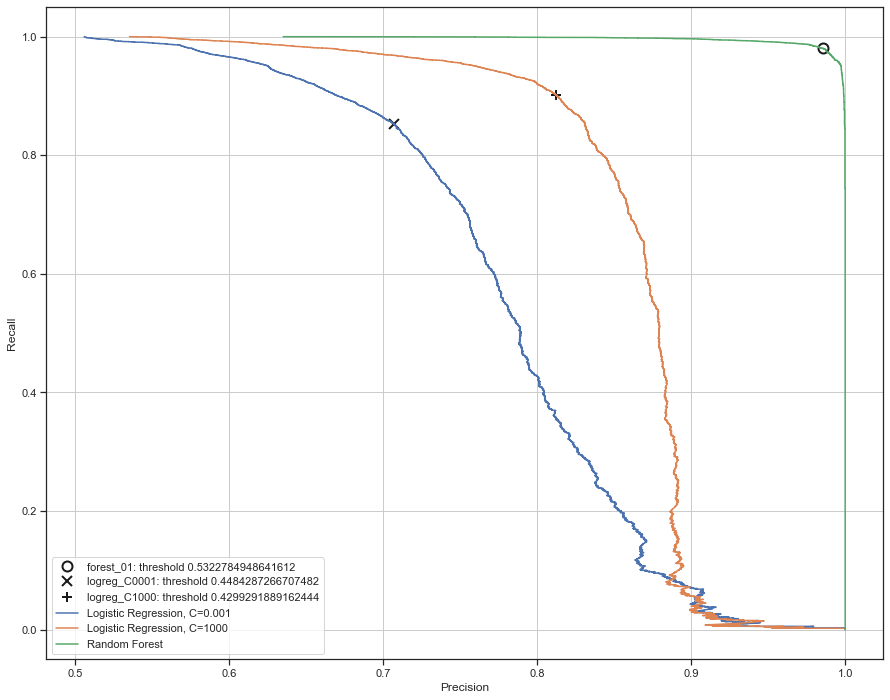

In [57]:
prec_rec_curve(X_train_balanced,y_train_balanced)

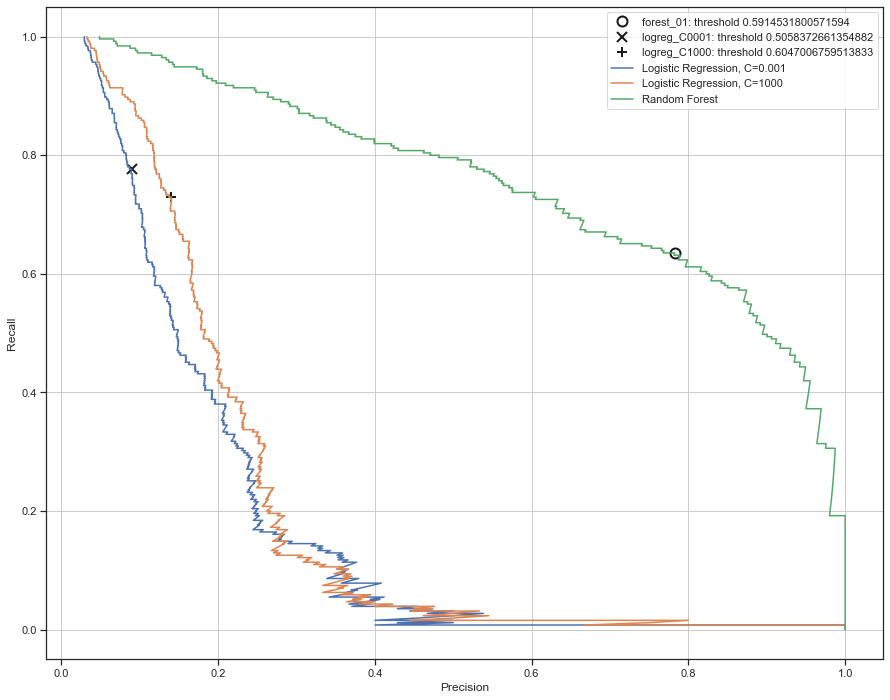

In [58]:
prec_rec_curve(X_train,y_train)

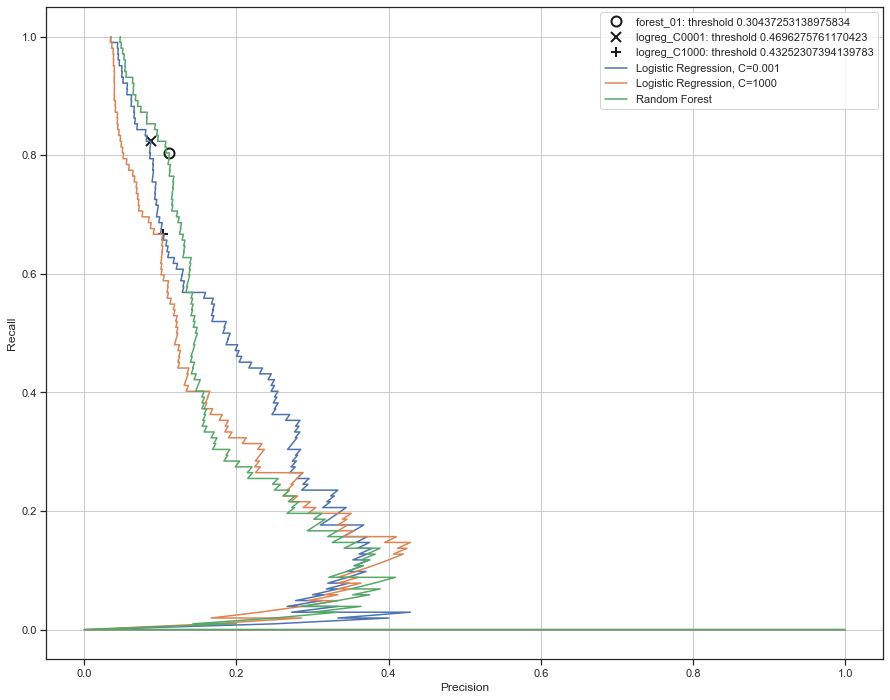

In [59]:
prec_rec_curve(X_test,y_test)

In [60]:
#boxplot_histogram(thresholds_logreg_C0001)

In [61]:
%%time
#Wall time: 19.7 s

from sklearn.metrics import average_precision_score # Area under the Recall/Precision-curves

avg_precision_logreg_C0001 = average_precision_score(y_test,
                                               logreg_C0001.predict_proba(X_test)[:, 1])

avg_precision_logreg_C1000 = average_precision_score(y_test,
                                               logreg_C1000.predict_proba(X_test)[:, 1])

avg_precision_forest_01 = average_precision_score(y_test,
                                               forest_01.predict_proba(X_test)[:, 1])


print("Average Precision of LogReg C=0.001: {:.3f}".format(avg_precision_logreg_C0001))
print("Average Precision of LogReg C=1000:  {:.3f}".format(avg_precision_logreg_C1000))
print("Average Precision of forest_01:      {:.3f}".format(avg_precision_forest_01))

Average Precision of LogReg C=0.001: 0.198
Average Precision of LogReg C=1000:  0.164
Average Precision of forest_01:      0.177
Wall time: 1.42 s


## Receiver Operating Characteristics (ROC) and AUC


In [62]:
%%time
from sklearn.metrics import roc_curve
def roc_curve_graph(X_test,y_test):
    global fpr_logreg_C0001, tpr_logreg_C0001, thresholds_logreg_C0001, fpr_logreg_C1000, tpr_logreg_C1000, thresholds_logreg_C1000, fpr_forest_01, tpr_forest_01, thresholds_forest_01
    fpr_logreg_C0001, tpr_logreg_C0001, thresholds_logreg_C0001 = roc_curve(y_test, logreg_C0001.predict_proba(X_test)[:, 1])
    fpr_logreg_C1000, tpr_logreg_C1000, thresholds_logreg_C1000 = roc_curve(y_test, logreg_C1000.predict_proba(X_test)[:, 1])
    fpr_forest_01, tpr_forest_01, thresholds_forest_01 = roc_curve(y_test, forest_01.predict_proba(X_test)[:, 1])

    def threshold_dot_50perc(fpr_forest_01,tpr_forest_01,thresholds_forest_01,name,dot):

        close_default_index_forest_01 = pd.Series.idxmin(np.power(1-pd.Series(tpr_forest_01),2)+np.power(pd.Series(fpr_forest_01),2))
        return plt.plot(fpr_forest_01[close_default_index_forest_01], tpr_forest_01[close_default_index_forest_01],
                 dot,
                 markersize=10,
                 label=f"{name} threshold: {thresholds_forest_01[close_default_index_forest_01]}",
                 fillstyle="none",
                 c='k',
                 mew=2)


    plt.figure(figsize=(15,12))
    plt.grid()

    plt.plot(fpr_forest_01,fpr_forest_01, linestyle='dotted', label="base line")

    plt.plot(fpr_logreg_C0001, tpr_logreg_C0001, label="logreg_C0001")
    plt.plot(fpr_logreg_C1000, tpr_logreg_C1000, label="logreg_C1000")
    plt.plot(fpr_forest_01,    tpr_forest_01,    label="forest_01")


    plt.xlabel("False-Postive Rate (FPR)")
    plt.ylabel("True-Positive Rate (TPR) aka. Recall")

    # find threshold closest to zero
    threshold_dot_50perc(fpr_forest_01,tpr_forest_01,     thresholds_forest_01,'forest_01',dot='^')
    threshold_dot_50perc(fpr_logreg_C0001, tpr_logreg_C0001, thresholds_logreg_C0001,'logreg_C0001',dot='x')
    threshold_dot_50perc(fpr_logreg_C1000,tpr_logreg_C1000,thresholds_logreg_C1000,'logreg_C1000',dot='+')

    plt.legend(loc=4)
    plt.show()

Wall time: 0 ns


In [63]:
%%time
# Wall time: 17.6s
from sklearn.metrics import roc_auc_score

def roc_auc(X_test,y_test):
    forest_01_auc    = roc_auc_score(y_test,    forest_01.predict_proba(X_test)[:, 1])
    logreg_C0001_auc = roc_auc_score(y_test, logreg_C0001.predict_proba(X_test)[:, 1])
    logreg_C1000_auc = roc_auc_score(y_test, logreg_C1000.predict_proba(X_test)[:, 1])


    print("AUC for forest_01:    {:.3f}".format(forest_01_auc))
    print("AUC for logreg_C0001: {:.3f}".format(logreg_C0001_auc))
    print("AUC for logreg_C1000: {:.3f}".format(logreg_C1000_auc))

Wall time: 0 ns


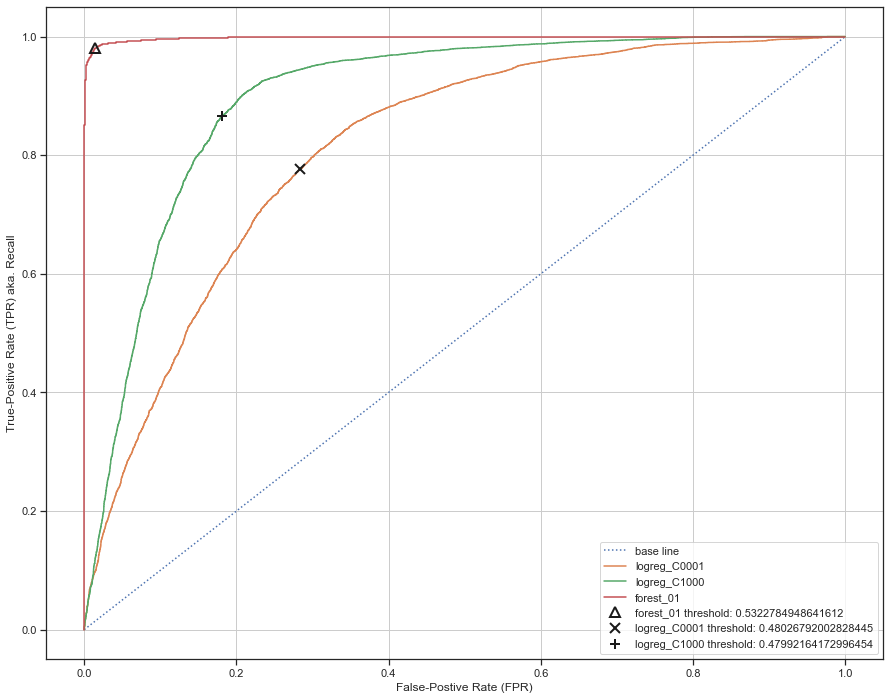

AUC for forest_01:    0.998
AUC for logreg_C0001: 0.813
AUC for logreg_C1000: 0.899
Wall time: 3.79 s


In [64]:
%%time
#Wall time: 10.6 s
roc_curve_graph(X_train_balanced,y_train_balanced)
roc_auc(X_train_balanced,y_train_balanced)

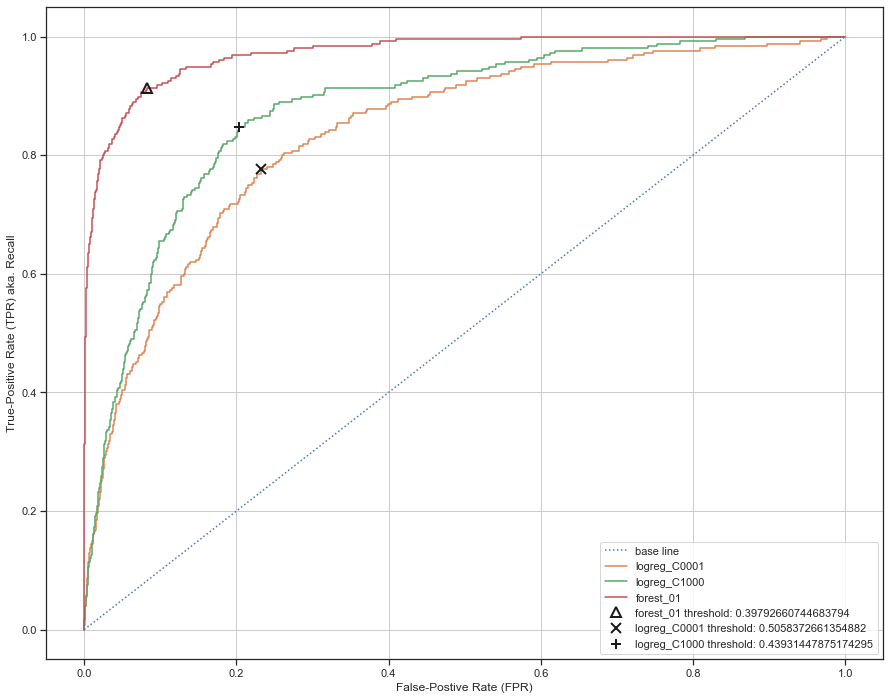

AUC for forest_01:    0.973
AUC for logreg_C0001: 0.838
AUC for logreg_C1000: 0.878
Wall time: 3.54 s


In [65]:
%%time
#Wall time: 10.6 s
roc_curve_graph(X_train,y_train)
roc_auc(X_train,y_train)

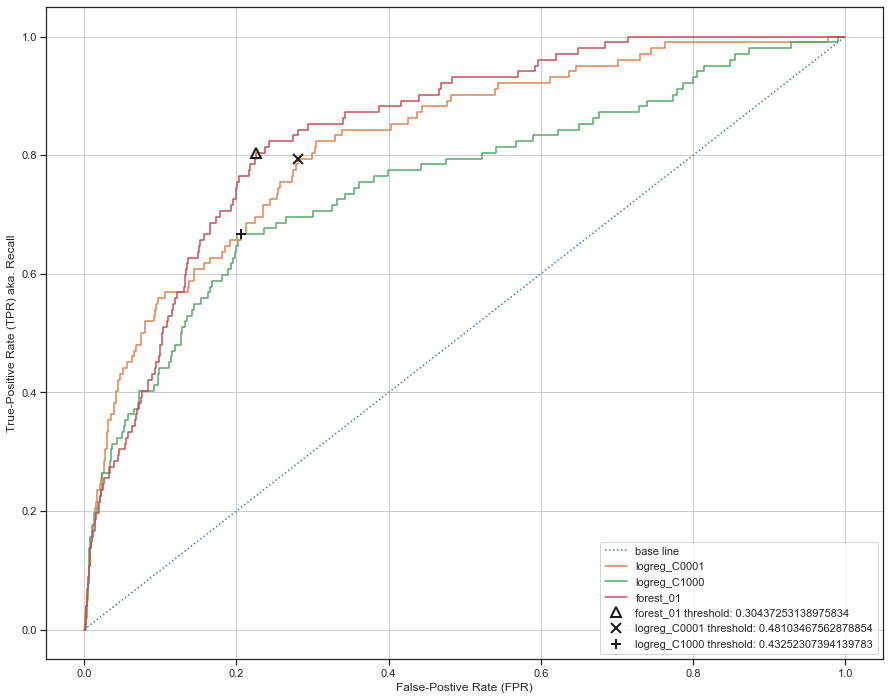

AUC for forest_01:    0.842
AUC for logreg_C0001: 0.824
AUC for logreg_C1000: 0.755
Wall time: 3.02 s


In [66]:
%%time
roc_curve_graph(X_test,y_test)
roc_auc(X_test,y_test)

## Recursive feature elimination with cross-validation

## Shapley values

https://medium.com/@santiagof/model-interpretability-making-your-model-confess-shapley-values-5fb95a10a624

# Scoring

## Score Class Probabilities (Booking: No/Yes)

In [67]:
scoring_prob     = forest_01.predict_proba(X_scoring)
scoring_prob_df  = pd.DataFrame(scoring_prob, columns=["Prob_0","Prob_1"])
scoring_all_prob = (pd.merge(scoring_all,
                             scoring_prob_df,
                             left_index=True,
                             right_index=True
                            ).sort_values("Prob_1",ascending=False)
                   )

In [68]:
scoring_all_prob.head()

,Endkunde_NR,Kampagne_Erfass_Datum_min,Kampagne_Erfass_Datum_max,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,Netto_Sum_Aus_RY_0_KW_21,Netto_Sum_Aus_RY_0_KW_23,Netto_Sum_Aus_RY_0_KW_25,Netto_Sum_Aus_RY_0_KW_27,Netto_Sum_Aus_RY_0_KW_29,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_0_KW_31,Netto_Sum_Aus_RY_0_KW_33,Netto_Sum_Aus_RY_0_KW_35,Netto_Sum_Aus_RY_0_KW_37,Netto_Sum_Aus_RY_0_KW_39,Netto_Sum_Aus_RY_0_KW_41,Netto_Sum_Aus_RY_0_KW_5,Netto_Sum_Aus_RY_0_KW_7,Netto_Sum_Aus_RY_0_KW_9,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,Netto_Sum_Aus_RY_3_KW_7,Netto_Sum_Aus_RY_3_KW_9,Netto_Sum_Aus_RY_4_KW_43,Netto_Sum_Aus_RY_4_KW_45,Netto_Sum_Aus_RY_4_KW_47,Netto_Sum_Aus_RY_4_KW_49,Netto_Sum_Aus_RY_4_KW_51,Netto_Sum_Res_RY_0_KW_1,Netto_Sum_Res_RY_0_KW_11,Netto_Sum_Res_RY_0_KW_13,Netto_Sum_Res_RY_0_KW_15,Netto_Sum_Res_RY_0_KW_17,Netto_Sum_Res_RY_0_KW_19,Netto_Sum_Res_RY_0_KW_21,Netto_Sum_Res_RY_0_KW_23,Netto_Sum_Res_RY_0_KW_25,Netto_Sum_Res_RY_0_KW_27,Netto_Sum_Res_RY_0_KW_29,Netto_Sum_Res_RY_0_KW_3,Netto_Sum_Res_RY_0_KW_31,Netto_Sum_Res_RY_0_KW_33,Netto_Sum_Res_RY_0_KW_35,Netto_Sum_Res_RY_0_KW_37,Netto_Sum_Res_RY_0_KW_39,Netto_Sum_Res_RY_0_KW_41,Netto_Sum_Res_RY_0_KW_5,Netto_Sum_Res_RY_0_KW_7,Netto_Sum_Res_RY_0_KW_9,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_13,Netto_Sum_Res_RY_2_KW_15,Netto_Sum_Res_RY_2_KW_1

## Cutoff: Selecting the customers with the highest chances for a sale

Check the distribution to define a reasonable cut-off:

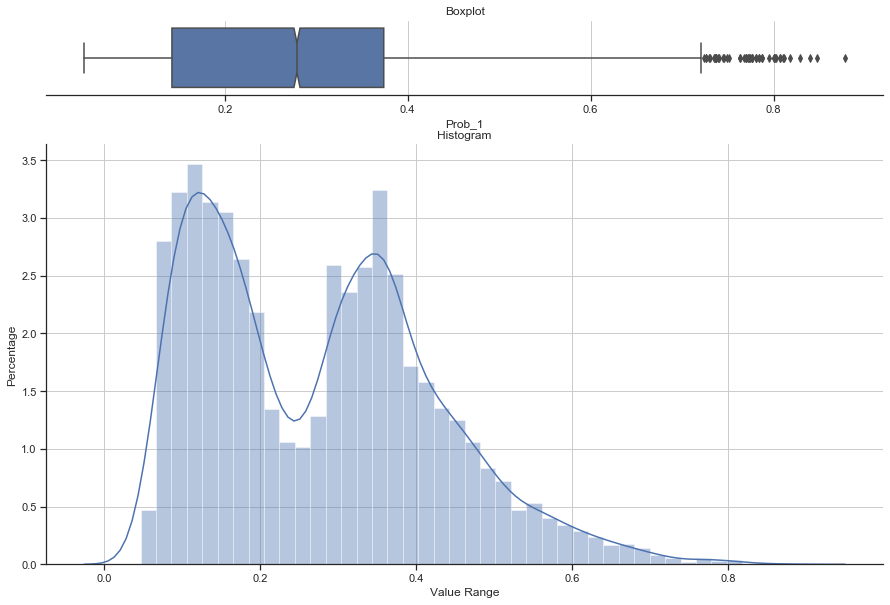

count    12012.000000
mean         0.275774
std          0.149335
min          0.046406
25%          0.142323
50%          0.278994
75%          0.373847
max          0.878051
Name: Prob_1, dtype: float64

In [69]:
boxplot_histogram(scoring_all_prob.loc[:,"Prob_1"])
scoring_all_prob.loc[:,"Prob_1"].describe()


In [70]:
def cutoff_by_quantile(dataframe, quantile=0.75):
    """
    Input: 
        - Dataframe with Probabilities for a reservation
        - Quantile
    
    Output:
        - Subset of initial dataframe cutoff via defined Quantile
    """
    quantile_75      = dataframe.Prob_1.quantile([quantile]).iloc[0]
    filter_col       = (dataframe.loc[:,"Prob_1"] > quantile_75)
    dataframe_cutoff = dataframe.loc[filter_col,:]
    print(f"Dataset: {dataframe_cutoff.shape[0]} out of {dataframe.shape[0]} selected")
    print(f"Cutoff:  {quantile_75} (minimum predicted probability for a reservation)")
    return dataframe_cutoff

In [71]:
ek_list_cutoff = cutoff_by_quantile(dataframe=scoring_all_prob,quantile=0.75)

Dataset: 3003 out of 12012 selected
Cutoff:  0.37384736719067196 (minimum predicted probability for a reservation)


## Adding additional information for delivery lists ``EK_LIST_2W_KOMPLETT.csv``

In [72]:
from pa_lib.file import load_bin

In [86]:
ek_info = load_bin("vkprog\\ek_info.feather")

2019-10-28 18:53:18 [INFO] Started loading binary file
2019-10-28 18:53:18 [INFO] Reading from file C:\Users\stc\data\vkprog\ek_info.feather
2019-10-28 18:53:18 [INFO] Finished loading binary file in 0.04s (0.05s CPU)


In [87]:
display(desc_col(ek_info))
display(ek_info.head())
print(ek_info.shape)

,DTYPE,NULLS,UNIQUE
index,int64,0/32237,32237
Endkunde_NR,int64,0/32237,32237
Endkunde,object,0/32237,30291
EK_Aktiv,int64,0/32237,2
EK_Kam_Betreut,int64,0/32237,2
EK_Land,object,49/32188,45
PLZ,int64,0/32237,2875
GEMEINDE,object,49/32188,3006
Agentur,object,20999/11238,3247
EK_BG,object,1829/30408,83


,index,Endkunde_NR,Endkunde,EK_Aktiv,EK_Kam_Betreut,EK_Land,PLZ,GEMEINDE,Agentur,EK_BG,EK_BG_ID,Auftrag_BG_ID,Auftrag_BG_Anz,Last_Res_Date,First_Res_Year,Last_Res_Year,Last_Aus_Date,EK_HB_Apg_Kurzz,AG_Hauptbetreuer,KANTON,BEZIRK,REGION,GROSSREGION,VERKAUFS_GEBIETS_CODE,VB_VKGEB,Letzter_Kontakt,Kanal,Betreff,Letzte_CRM_Ktkts,Net_2015,Net_2016,Net_2017,Net_2018,Net_2019,Verkaufsberater
0,0,100034,Maurer + Salzmann AG,1,0,SCHWEIZ,8408,Winterthur,ACE 2 ACE outdoor media ag,WG - Dienstleistung,720,"720,405,400,295",4,2018-10-31,2009,2018,2018-11-12,ACO,NYI,ZH,Winterthur,Winterthur,Region Zürich,V-O02,CGA,IWI,E-Mail,Ost - Aktionen 2019 - ACO_Dispo_Eröffnung 1. H...,"HKL,ACO,BAC,LAH,BBO,JAU,LSC,IWI,MBU",NaN,NaN,NaN,NaN,NaN,None
1,1,100039,Bank BSU Genossenschaft,1,0,SCHWEIZ,8610,Uster,"walder, werber werbeagentur ag",WG - Finanzwirtschaft,470,"470,720",2,2019-09-01,2009,2019,2019-12-01,MBU,CGA,ZH,Uster,Uster–Dübendorf,Region Zürich,V-O03,ACO,IWI,E-Mail,Ost - Aktionen 2019 - CGA_Dispo_Eröffnung 1. H...,"DM,ROK,JDI,AKU,HUL,CGA,LSC,IWI",7500.0,7500.0,7700.0,7700.0,3700.0,MBU
2,2,100061,Mundwiler Juwelen AG,1,0,SCHWEIZ,8400,Winterthur,None,WG - Persönlicher Bedarf,555,555,1,2009-09-16,2009,2009,2009-10-12,ACO,None,ZH,Winterthur,Winterthur,Region Zürich,V-O02,CGA,IWI,E-Mail,Ost - Aktionen 2019 - ACO_Dispo_Eröffnung 1. H...,"ACO,BAC,HKL,BAP,JAU,LSC,IWI",NaN,NaN,NaN,NaN,NaN,None
3,3,100064,Senn Communication,1,0,SCHWEIZ,8610,Uster,None,WG - Dienstleistung,720,"901,960",2,2019-10-04,2009,2019,2020-01-01,MBU,None,ZH,Uster,Uster–Dübendorf,Region Zürich,V-O03,ACO,MBU,Telefon,Offerte,"AKU,DM,MBU,ROK,JDI,CAS,LSC,BAP,IWI",2000.0,2000.0,1441.0,0.0,10900.0,MBU
4,4,100066,"walder, werber werbeagentur ag",1,0,SCHWEIZ,8610,Uster,None,WG - Dienstleistung,720,"780,720",2,2018-09-13,2013,2018,2018-10-01,MBU,None,ZH,Uster,Uster–Dübendorf,Region Zürich,V-O03,ACO,IWI,E-Mail,Ost - Aktionen 2019 - CGA_Dispo_Eröffnung 1. H...,"HKL,AKU,DM,IWI,CAS,ROK,CGA,JDI,JCO,MBU,LAH,BBO...",NaN,NaN,NaN,NaN,NaN,None


(32237, 35)


In [76]:
ek_list = pd.merge(ek_list_cutoff,ek_info,on="Endkunde_NR", how="left")

In [78]:
ek_list.sample(5,random_state=42)

,Endkunde_NR,Kampagne_Erfass_Datum_min,Kampagne_Erfass_Datum_max,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,Netto_Sum_Aus_RY_0_KW_21,Netto_Sum_Aus_RY_0_KW_23,Netto_Sum_Aus_RY_0_KW_25,Netto_Sum_Aus_RY_0_KW_27,Netto_Sum_Aus_RY_0_KW_29,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_0_KW_31,Netto_Sum_Aus_RY_0_KW_33,Netto_Sum_Aus_RY_0_KW_35,Netto_Sum_Aus_RY_0_KW_37,Netto_Sum_Aus_RY_0_KW_39,Netto_Sum_Aus_RY_0_KW_41,Netto_Sum_Aus_RY_0_KW_5,Netto_Sum_Aus_RY_0_KW_7,Netto_Sum_Aus_RY_0_KW_9,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,Netto_Sum_Aus_RY_3_KW_7,Netto_Sum_Aus_RY_3_KW_9,Netto_Sum_Aus_RY_4_KW_43,Netto_Sum_Aus_RY_4_KW_45,Netto_Sum_Aus_RY_4_KW_47,Netto_Sum_Aus_RY_4_KW_49,Netto_Sum_Aus_RY_4_KW_51,Netto_Sum_Res_RY_0_KW_1,Netto_Sum_Res_RY_0_KW_11,Netto_Sum_Res_RY_0_KW_13,Netto_Sum_Res_RY_0_KW_15,Netto_Sum_Res_RY_0_KW_17,Netto_Sum_Res_RY_0_KW_19,Netto_Sum_Res_RY_0_KW_21,Netto_Sum_Res_RY_0_KW_23,Netto_Sum_Res_RY_0_KW_25,Netto_Sum_Res_RY_0_KW_27,Netto_Sum_Res_RY_0_KW_29,Netto_Sum_Res_RY_0_KW_3,Netto_Sum_Res_RY_0_KW_31,Netto_Sum_Res_RY_0_KW_33,Netto_Sum_Res_RY_0_KW_35,Netto_Sum_Res_RY_0_KW_37,Netto_Sum_Res_RY_0_KW_39,Netto_Sum_Res_RY_0_KW_41,Netto_Sum_Res_RY_0_KW_5,Netto_Sum_Res_RY_0_KW_7,Netto_Sum_Res_RY_0_KW_9,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_13,Netto_Sum_Res_RY_2_KW_15,Netto_Sum_Res_RY_2_KW_1

In [79]:
ek_list.shape

(3003, 375)

In [89]:
# Check _col_selection_ in file "vp2xlsx.py". It's the only one that actually counts! Compare with R-code to figure out the meaning.

listing = ['Endkunde_NR',      # Endkunde_NR
           "Endkunde",         # Endkunde
           "EK_HB_Apg_Kurzz",  # HB_APG (based on R-script)
           "Agentur",          # Agentur
           "AG_Hauptbetreuer", # HB_Agentur   
           "PLZ",              # PLZ
           "GEMEINDE",         # Ort
           
           "Net_2016",
           "Net_2017",
           "Net_2018",
           "Net_2019",      # (bd, aggregiert)
           "letzte_VBs",     # (bd, aggregiert)
           
           "Letzte_CRM_Ktkts",  # ACTUALLY NOT NEEDED! I fail.
           "Letzter_Kontakt", # KZ_letzter_Ktkt (crm)
           "Kanal",           #(crm)
           "Betreff",         #(crm)
           
           "Last_Res_Date", # Letzte_Kamp_erfasst
           "Last_Aus_Date", # letzte_Kamp_Beginn
           "VERKAUFS_GEBIETS_CODE", # Verkaufsgebiet
           "VB_VKGEB",      
           "Prob_1"]        # prob_KW (from here, good good.)

test_df = ek_list.loc[:,listing]
test_df.shape

(3003, 21)

In [94]:
desc_col(test_df)
#this is a test

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/3003,3003
Endkunde,object,0/3003,2937
EK_HB_Apg_Kurzz,object,11/2992,49
Agentur,object,1707/1296,646
AG_Hauptbetreuer,object,1714/1289,70
PLZ,int64,0/3003,934
GEMEINDE,object,1/3002,849
Net_2016,float64,3003/0,0
Net_2017,float64,3003/0,0
Net_2018,float64,3003/0,0


In [92]:
#row_select = test_df.VERKAUFS_GEBIETS_CODE.isna()
#display(test_df.loc[row_select,:])

display(test_df.sort_values("Net_2019", ascending=True).head(5))

,Endkunde_NR,Endkunde,EK_HB_Apg_Kurzz,Agentur,AG_Hauptbetreuer,PLZ,GEMEINDE,Net_2016,Net_2017,Net_2018,Net_2019,letzte_VBs,Letzte_CRM_Ktkts,Letzter_Kontakt,Kanal,Betreff,Last_Res_Date,Last_Aus_Date,VERKAUFS_GEBIETS_CODE,VB_VKGEB,Prob_1
0,117831,Commune de Meyrin,SIB,None,None,1217,Meyrin 1,NaN,NaN,NaN,NaN,NaN,"HOF,LIC,SIB,AAN",SIB,E-Mail,RE: Réservations 2020-1 : Soyez les premiers à...,2019-02-28,2019-09-30,V-W01,SIB,0.878051
1,630837,Musikverein Interlaken Unterseen,CBA,None,None,3800,Unterseen,NaN,NaN,NaN,NaN,NaN,"KIU,NAT,SGU1,BAP,BIM,LSC,JAN,MAL,CJA",CJA,E-Mail,Verkauf Bern Mitte 2019 - Dispoeröffnung 2020 ...,2019-10-06,2019-11-18,V-M05,JAN,0.847439
2,162474,Compagnie les Arts,SIB,None,None,1211,Genève 4,NaN,NaN,NaN,NaN,NaN,"HOF,AAN,LIC,SIB",SIB,E-Mail,RE: Réservations 2020-1 : Soyez les premiers à...,2019-03-13,2019-09-16,V-W01,SIB,0.839852
3,633485,Cool Kids Sàrl,VRA,None,None,1820,Veytaux,NaN,NaN,NaN,NaN,NaN,"GPE,MZB,LIC",LIC,E-Mail,Ouest - Aktionen 2019 - Ouverture dispo 2020-1...,2018-11-01,2019-01-07,V-W03,MZB,0.829042
4,122787,Théâtre des Marionnettes de Genève,SIB,None,None,1211,Genève 4,NaN,NaN,NaN,NaN,NaN,"HOF,BAP,LIC,AAN,SIB",SIB,E-Mail,TR: Réservations 2020-1 : Soyez les premiers à...,2019-03-06,2019-11-18,V-W01,SIB,0.818296


# Appendix

## Mutual Information

In [ ]:
%%time
mu_in = mutual_info_classif(X_train_balanced,y_train_balanced) / mutual_info_classif(y_train_balanced.reshape(-1,1),y_train_balanced)

In [ ]:
print(mu_in.shape)
print(feature_columns.shape)

In [ ]:
 mu_in_df = (pd.DataFrame({'Feature':            feature_columns,
                           'Mutual_Information': mu_in})
             .sort_values(by='Mutual_Information',
                          ascending=False)
             .reset_index(drop=True)
            )

In [ ]:
display(mu_in_df.head(50))

In [ ]:
boxplot_histogram(mu_in_df.loc[:,'Mutual_Information'])

In [ ]:
def mu_in_cutoff(cutoff):
    display(mu_in_df.loc[mu_in_df.loc[:,'Mutual_Information'] >= cutoff,:])

In [ ]:
mu_in_cutoff(0.07)

In [ ]:
mu_in_df['scaled'] = mu_in_df['Mutual_Information'] / mu_in_df['Mutual_Information'].sum()

In [ ]:
mu_in_df['cum'] = mu_in_df['scaled'].cumsum()

In [ ]:
plt.figure(figsize=(15,50))
sns.barplot(x   = 'Mutual_Information',
            y   = 'Feature',
            data= mu_in_df)

## Univariate Analysis

In [ ]:
for feature in feature_columns:
    print(feature)
    print(len(training_all.loc[training_all.loc[:,feature] > 0, feature]))
    boxplot_histogram(training_all.loc[training_all.loc[:,feature] > 0, feature])

## Bivariate Analysis

In [ ]:
training_all.describe()

In [ ]:
print(training_all.columns)

In [ ]:
def hexbin(dataset, first_feature,second_feature,gridsize=25):
    dataset.plot.hexbin(x=first_feature, y=second_feature , gridsize=gridsize, figsize=(12,8))

In [ ]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=10, cmap=cmap, **kwargs)

with sns.axes_style("dark"):
    g = sns.FacetGrid(training_all,
                      hue="Target_Res_flg",
                      col="Target_Res_flg",
                      height=10
                     )

g.map(hexbin,
      "Netto_Sum_Aus_RY_0_KW_1",
      "Erste_Buchung_Delta",
      extent=[0, 1, 0, 1]
     )

In [ ]:
%%time
sns.axes_style("darkgrid")

sns.pairplot(data   = training_all.loc[:,["Target_Res_flg"]+list(mu_in_df.head(20).loc[:,"Feature"])],
             diag_kind="kde",
             hue    = "Target_Res_flg",
             height =5
            ).savefig("derp.png")
